In [1]:
!date

Sun Feb  6 23:00:48 PST 2022


# Cell type assignment on only CTRL data
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [3]:
import sys
import anndata
import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
# set random seed
np.random.seed(926)

In [5]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load clustered CTRL data  
Difference to v1 notebook:  
Clustering with n_pcs = 50 (instead of 10 in v1)  

In [6]:
adata = anndata.read('../../finchseq_data/ctrl_leiden_v2.h5ad')
adata

AnnData object with n_obs × n_vars = 15810 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

Create copy of adata to run rank_genes_groups on marker genes only:

In [7]:
adata_test = adata.copy()

___

# Plot fraction of each ctrl batch per cluster (after normalizing to total cellcount in each batch):

In [8]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_control = (adata.obs.groupby("leiden")["batch"].value_counts() / adata.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_control.columns = df_control.columns.astype(str)

df_control["total normalized count"] = df_control.sum(axis=1).values

df_control["control1_fraction"] = (df_control["control1"] / df_control["total normalized count"]).values
df_control["control2_fraction"] = (df_control["control2"] / df_control["total normalized count"]).values

df_control["total number of cells"] = adata.obs.groupby("leiden").size().values.astype(int)

df_control.head()

batch   control1  control2  total normalized count  control1_fraction  \
leiden                                                                  
0       0.178736  0.171986                0.350722           0.509623   
1       0.093311  0.126344                0.219655           0.424809   
2       0.079484  0.109807                0.189290           0.419904   
3       0.092492  0.049446                0.141938           0.651637   
4       0.077230  0.049115                0.126346           0.611263   

batch   control2_fraction  total number of cells  
leiden                                            
0                0.490377                   2785  
1                0.575191                   1675  
2                0.580096                   1440  
3                0.348363                   1202  
4                0.388737                   1051

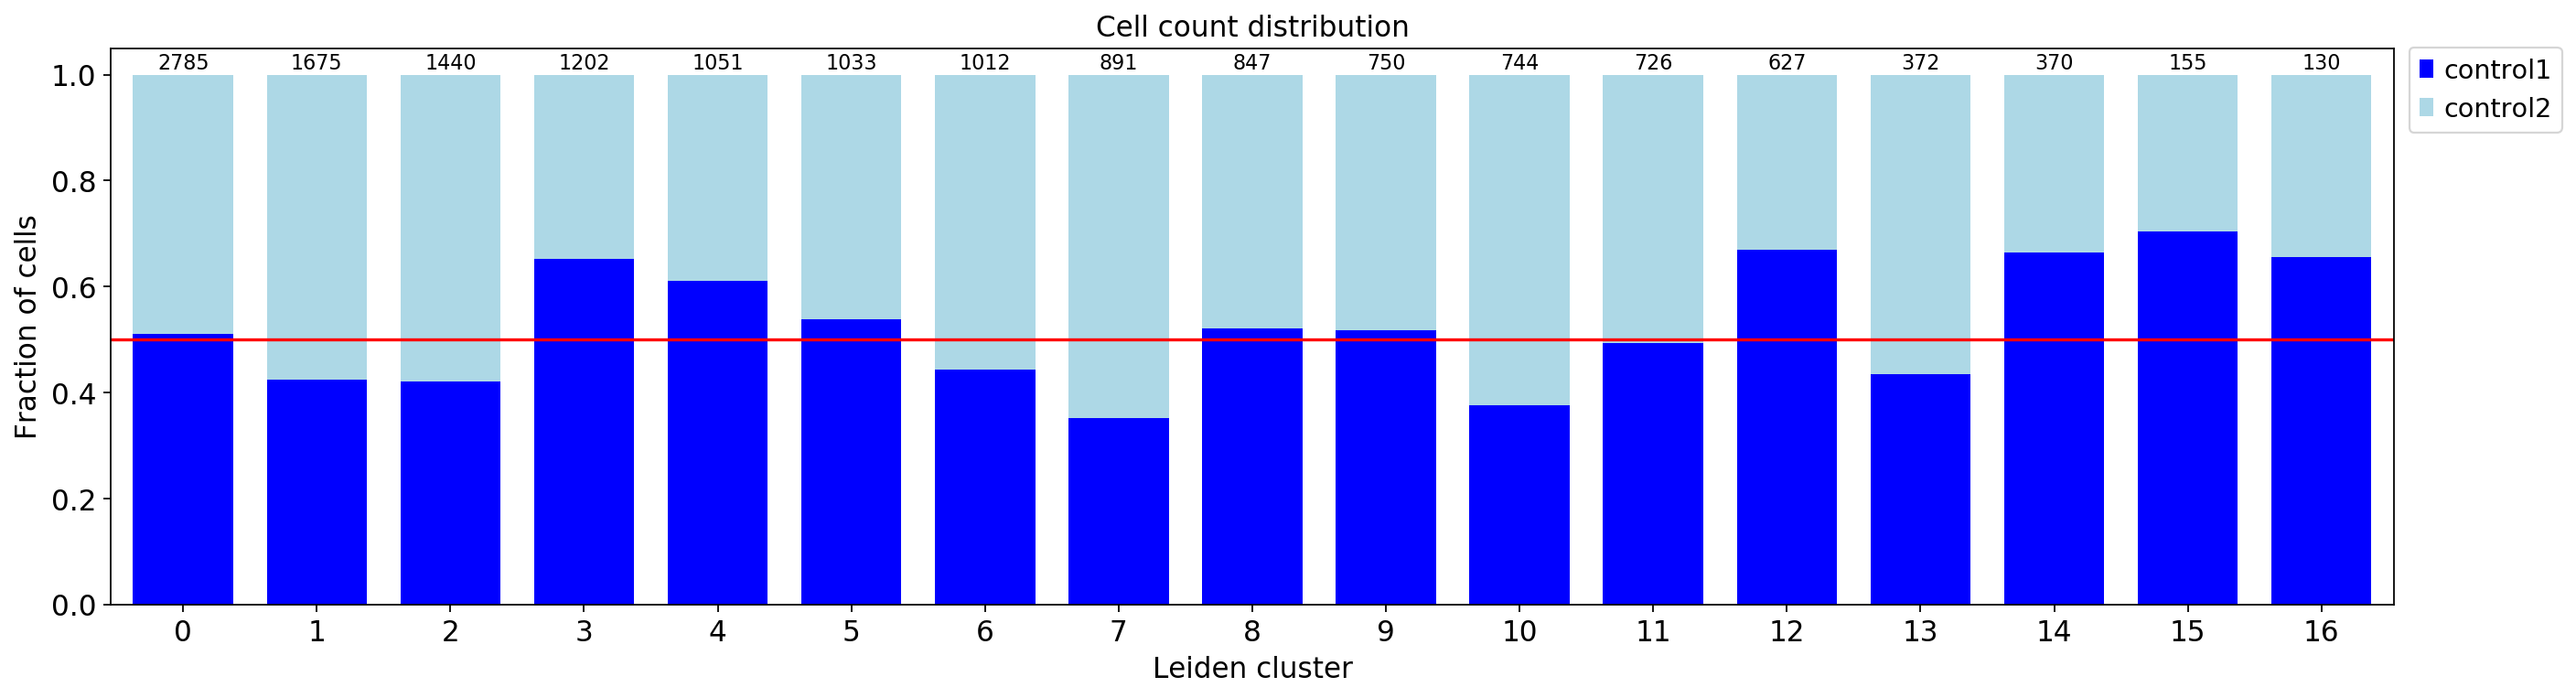

In [9]:
fig, ax = plt.subplots(figsize=(20,5))

clusters = df_control.index.values
width = 0.75

ax.bar(clusters, df_control["control1_fraction"].values, width, color="blue", label="control1")
ax.bar(clusters, df_control["control2_fraction"].values, width, bottom=df_control["control1_fraction"].values, color="lightblue", label="control2")

cellcounts = df_control["total number of cells"].values
# Add total cell count above each bar
for index, value in enumerate(cellcounts):
    ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

ax.set_xticklabels(clusters, rotation = 0, ha="center")
ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

ax.set(**{
    "title": "Cell count distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Leiden cluster"
})

ax.axhline(y=0.5, color='r', linestyle='-')

ax.margins(x=0.01)
ax.grid(False) 

fig.show()

No obvious batch effect can be observed.

___

# DE genes in CTRL Leiden clusters

In [10]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test', corr_method="bonferroni", use_raw=False)

Score = z-score underlying the computation of a p-value for each gene for each group

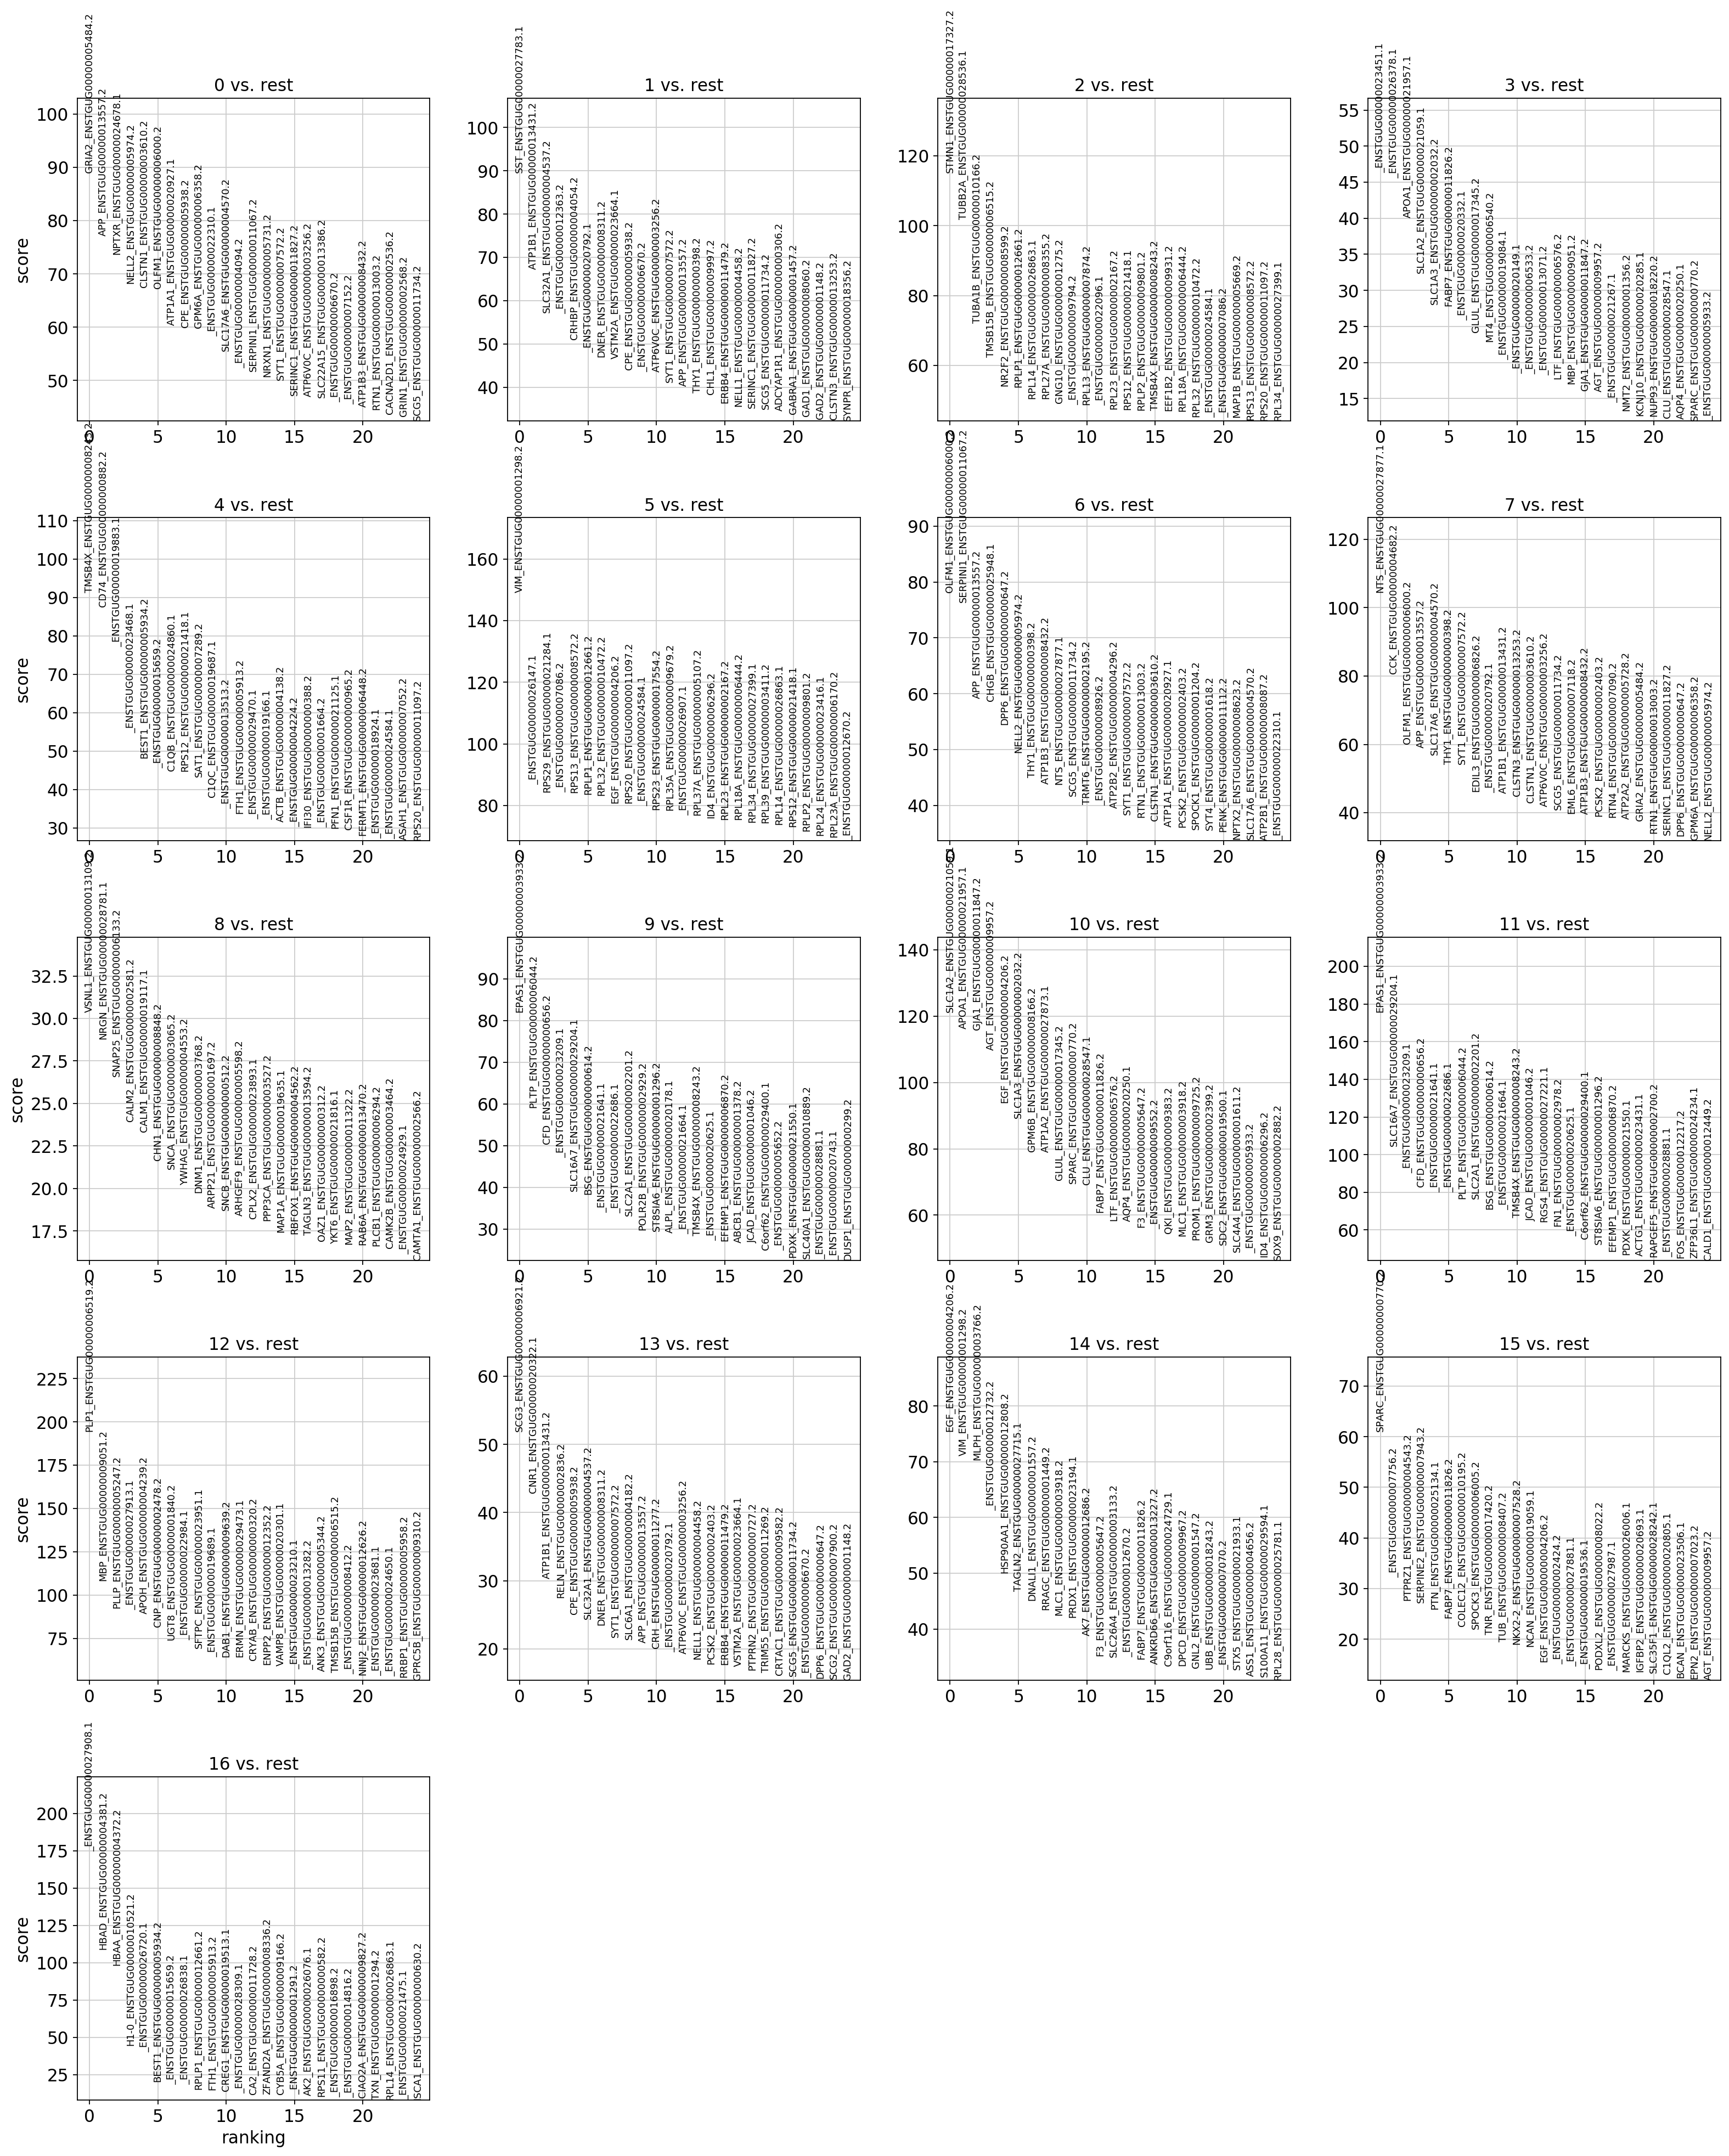

In [11]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save=True)

Show the 10 top ranked genes per cluster:

In [12]:
leiden_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25)
leiden_markers

0                               1  \
0      GRIA2_ENSTGUG00000005484.2        SST_ENSTGUG00000027783.1   
1        APP_ENSTGUG00000013557.2     ATP1B1_ENSTGUG00000013431.2   
2      NPTXR_ENSTGUG00000024678.1    SLC32A1_ENSTGUG00000004537.2   
3      NELL2_ENSTGUG00000005974.2           _ENSTGUG00000012363.2   
4     CLSTN1_ENSTGUG00000003610.2      CRHBP_ENSTGUG00000004054.2   
5      OLFM1_ENSTGUG00000006000.2           _ENSTGUG00000020792.1   
6     ATP1A1_ENSTGUG00000020927.1       DNER_ENSTGUG00000008311.2   
7        CPE_ENSTGUG00000005938.2     VSTM2A_ENSTGUG00000023664.1   
8      GPM6A_ENSTGUG00000006358.2        CPE_ENSTGUG00000005938.2   
9           _ENSTGUG00000022310.1           _ENSTGUG00000006670.2   
10   SLC17A6_ENSTGUG00000004570.2    ATP6V0C_ENSTGUG00000003256.2   
11          _ENSTGUG00000004094.2       SYT1_ENSTGUG00000007572.2   
12  SERPINI1_ENSTGUG00000011067.2        APP_ENSTGUG00000013557.2   
13     NRXN1_ENSTGUG00000005731.2       THY1_ENSTGUG00000000398.2   
14      SYT1_ENSTGUG00000007572.2       CHL1_ENSTGUG00000009997.2   
15   SERINC1_ENSTGUG00000011827.2      ERBB4_ENSTGUG00000011479.2   
16   ATP6V0C_ENSTGUG00000003256.2      NELL1_ENSTGUG00000004458.2   
17  SLC22A15_ENSTGUG00000013386.2    SERINC1_ENSTGUG00000011827.2   
18          _ENSTGUG00000006670.2       SCG5_ENSTGUG00000011734.2   
19          _ENSTGUG00000007152.2  ADCYAP1R1_ENSTGUG00000000306.2   
20    ATP1B3_ENSTGUG00000008432.2     GABRA1_ENSTGUG00000001457.2   
21      RTN1_ENSTGUG00000013003.2       GAD1_ENSTGUG00000008060.2   
22  CACNA2D1_ENSTGUG00000002536.2       GAD2_ENSTGUG00000001148.2   
23     GRIN1_ENSTGUG00000002568.2     CLSTN3_ENSTGUG00000013253.2   
24      SCG5_ENSTGUG00000011734.2      SYNPR_ENSTGUG00000018356.2   

                               2                            3  \
0     STMN1_ENSTGUG00000017327.2        _ENSTGUG00000023451.1   
1    TUBB2A_ENSTGUG00000028536.1        _ENSTGUG00000026378.1   
2    TUBA1B_ENSTGUG00000010166.2   APOA1_ENSTGUG00000021957.1   
3   TMSB15B_ENSTGUG00000006515.2  SLC1A2_ENSTGUG00000021059.1   
4     NR2F2_ENSTGUG00000008599.2  SLC1A3_ENSTGUG00000002032.2   
5     RPLP1_ENSTGUG00000012661.2   FABP7_ENSTGUG00000011826.2   
6     RPL14_ENSTGUG00000026863.1        _ENSTGUG00000020332.1   
7    RPL27A_ENSTGUG00000008355.2    GLUL_ENSTGUG00000017345.2   
8     GNG10_ENSTGUG00000001275.2     MT4_ENSTGUG00000006540.2   
9          _ENSTGUG00000009794.2        _ENSTGUG00000019084.1   
10    RPL13_ENSTGUG00000007874.2        _ENSTGUG00000020149.1   
11         _ENSTGUG00000022096.1        _ENSTGUG00000006533.2   
12    RPL23_ENSTGUG00000002167.2        _ENSTGUG00000013071.2   
13    RPS12_ENSTGUG00000021418.1     LTF_ENSTGUG00000006576.2   
14    RPLP2_ENSTGUG00000009801.2     MBP_ENSTGUG00000009051.2   
15   TMSB4X_ENSTGUG00000008243.2    GJA1_ENSTGUG00000011847.2   
16   EEF1B2_ENSTGUG00000009931.2     AGT_ENSTGUG00000009957.2   
17   RPL18A_ENSTGUG00000006444.2        _ENSTGUG00000021267.1   
18    RPL32_ENSTGUG00000010472.2    NMT2_ENSTGUG00000001356.2   
19         _ENSTGUG00000024584.1  KCNJ10_ENSTGUG00000020285.1   
20         _ENSTGUG00000007086.2   NUP93_ENSTGUG00000018220.2   
21    MAP1B_ENSTGUG00000005669.2     CLU_ENSTGUG00000028547.1   
22    RPS13_ENSTGUG00000008572.2    AQP4_ENSTGUG00000020250.1   
23    RPS20_ENSTGUG00000011097.2   SPARC_ENSTGUG00000000770.2   
24    RPL34_ENSTGUG00000027399.1        _ENSTGUG00000005933.2   

                              4                            5  \
0   TMSB4X_ENSTGUG00000008243.2     VIM_ENSTGUG00000001298.2   
1     CD74_ENSTGUG00000000882.2        _ENSTGUG00000026147.1   
2         _ENSTGUG00000019883.1   RPS29_ENSTGUG00000021284.1   
3         _ENSTGUG00000023468.1        _ENSTGUG00000007086.2   
4    BEST1_ENSTGUG00000005934.2   RPS13_ENSTGUG00000008572.2   
5         _ENSTGUG00000015659.2   RPLP1_ENSTGUG00000012661.2   
6     C1QB_ENSTGUG00000024860.1   RPL32_ENSTGUG00000010472.2   
7    RPS12_ENSTGUG00000021418.1   

In [13]:
# leiden_markers.to_csv("leiden_marker_genes_ctrl.csv", index=False)

___

# Load previously known marker genes

In [14]:
marker_gene_mat = pd.read_excel('marker_genes.xlsx', sheet_name="matrix_v2")

Find gene ID for each gene:

In [15]:
marker_gene_mat["gene_name_id"] = np.arange(len(marker_gene_mat))

In [16]:
# index counter
i = 0

for gene in marker_gene_mat["Gene"].values:
    gene_name_id = []
    
    if gene.startswith("ENS"):
        gni = adata.var.iloc[np.where(adata.var.index.str.contains(gene))]
    
    else:
        gni = adata.var.iloc[np.where(adata.var.index.str.startswith(gene))]

    if len(gni) > 0:
        gene_name_id = gni.index[0]
    else:
        gene_name_id = np.nan

    marker_gene_mat["gene_name_id"][i] = gene_name_id
    i += 1

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### !!! Check which/if genes were found correctly:

In [17]:
marker_gene_mat[["Gene", "gene_name_id"]]

Gene                    gene_name_id
0              SLC15A2    SLC15A2_ENSTGUG00000026244.1
1                SPEF2      SPEF2_ENSTGUG00000001981.2
2                 PLP1       PLP1_ENSTGUG00000006519.2
3                CSF1R      CSF1R_ENSTGUG00000000965.2
4                 FLI1       FLI1_ENSTGUG00000020175.1
5                 RGS5       RGS5_ENSTGUG00000019064.1
6                  LUM        LUM_ENSTGUG00000008175.2
7                 HBAD       HBAD_ENSTGUG00000004381.2
8              SLC17A6    SLC17A6_ENSTGUG00000004570.2
9                 GAD1       GAD1_ENSTGUG00000008060.2
10                GAD2       GAD2_ENSTGUG00000001148.2
11               NR2E1      NR2E1_ENSTGUG00000012147.2
12                 DCX        DCX_ENSTGUG00000006180.2
13             NECTIN3    NECTIN3_ENSTGUG00000013600.2
14                TBR1       TBR1_ENSTGUG00000006709.2
15               FABP7      FABP7_ENSTGUG00000011826.2
16              NOTCH2     NOTCH2_ENSTGUG00000017231.2
17               UTS2B      UTS2B_ENSTGUG00000009278.2
18              HPCAL1     HPCAL1_ENSTGUG00000013044.2
19                 DCN        DCN_ENSTGUG00000008178.2
20                 NTS        NTS_ENSTGUG00000027877.1
21             ALDH1A2    ALDH1A2_ENSTGUG00000006178.2
22               FNDC9      FNDC9_ENSTGUG00000000654.2
23              COL6A3     COL6A3_ENSTGUG00000003667.2
24              NFATC1     NFATC1_ENSTGUG00000006621.2
25            ADAMTS18   ADAMTS18_ENSTGUG00000009163.2
26                 VIM        VIM_ENSTGUG00000001298.2
27                BDNF       BDNF_ENSTGUG00000004743.2
28               FOSL2      FOSL2_ENSTGUG00000024611.1
29              HOMER1     HOMER1_ENSTGUG00000003711.2
30  ENSTGUG00000007756           _ENSTGUG00000007756.2
31                SOX4                             NaN
32             or107-1                             NaN
33              EJZER1                             NaN
34               AR46s                             NaN
35                 DDC        DDC_ENSTGUG00000007930.2
36                 DBH        DBH_ENSTGUG00000005640.2
37               CASP3      CASP3_ENSTGUG00000006682.2
38               AIFM1      AIFM1_ENSTGUG00000005167.2
39                MCU_        MCU_ENSTGUG00000004428.2
40           TNFAIP8L3  TNFAIP8L3_ENSTGUG00000028388.1
41                EGR1       EGR1_ENSTGUG00000000003.2
42                E2F1       E2F1_ENSTGUG00000028557.1
43                MCM2       MCM2_ENSTGUG00000008031.2
44                MCM3       MCM3_ENSTGUG00000013275.2
45                MCM4       MCM4_ENSTGUG00000010897.2
46                MCM5       MCM5_ENSTGUG00000010831.2
47                MCM6       MCM6_ENSTGUG00000011790.2
48                PCNA       PCNA_ENSTGUG00000004036.2
49  ENSTGUG00000021193           _ENSTGUG00000021193.1

Notes on the marker genes:  
FNDC9 is a synonym for FNTM2 (HVC-X marker).  
PDGFRA (ENSTGUG00000007756.2) not annotated.  
or107-1 is a synonym for ZF1A (neither, not even ensembl ID, can be found in ref).  
Ki67 (ENSTGUG00000021193) not annotated. 

SOX4 and PDGFRA not in reference genome gtf. This is weird because Colquitt et al report using them as a markers and they use the same ref. genome.

ZF1A, EJZER1, and AR46s also not in ref gtf (not used in Colquitt paper).

In [18]:
# Drop rows with genes not found in dataset
marker_gene_mat = marker_gene_mat.dropna(axis=0)

# Drop columns of celltypes containing only 0s
marker_gene_mat = marker_gene_mat.loc[:, (marker_gene_mat != 0).any(axis=0)]
 
#Set gene_name_id as index and drop "gene" coplumn
marker_gene_mat = marker_gene_mat.set_index("gene_name_id")
marker_gene_mat = marker_gene_mat.drop("Gene", axis=1)

marker_gene_mat

neuron  glia  vascular  astrocytes  \
gene_name_id                                                         
SLC15A2_ENSTGUG00000026244.1         0     1         0           1   
SPEF2_ENSTGUG00000001981.2           0     1         0           0   
PLP1_ENSTGUG00000006519.2            0     1         0           0   
CSF1R_ENSTGUG00000000965.2           0     1         0           0   
FLI1_ENSTGUG00000020175.1            0     0         1           0   
RGS5_ENSTGUG00000019064.1            0     0         1           0   
LUM_ENSTGUG00000008175.2             0     0         0           0   
HBAD_ENSTGUG00000004381.2            0     0         1           0   
SLC17A6_ENSTGUG00000004570.2         1     0         0           0   
GAD1_ENSTGUG00000008060.2            1     0         0           0   
GAD2_ENSTGUG00000001148.2            1     0         0           0   
NR2E1_ENSTGUG00000012147.2           1     0         0           0   
DCX_ENSTGUG00000006180.2             1     0         0           0   
NECTIN3_ENSTGUG00000013600.2         1     0         0           0   
TBR1_ENSTGUG00000006709.2            1     0         0           0   
FABP7_ENSTGUG00000011826.2           1     0         0           0   
NOTCH2_ENSTGUG00000017231.2          1     0         0           0   
UTS2B_ENSTGUG00000009278.2           1     0         0           0   
HPCAL1_ENSTGUG00000013044.2          1     0         0           0   
DCN_ENSTGUG00000008178.2             1     0         0           0   
NTS_ENSTGUG00000027877.1             1     0         0           0   
ALDH1A2_ENSTGUG00000006178.2         1     0         0           0   
FNDC9_ENSTGUG00000000654.2           1     0         0           0   
COL6A3_ENSTGUG00000003667.2          1     0         0           0   
NFATC1_ENSTGUG00000006621.2          1     0         0           0   
ADAMTS18_ENSTGUG00000009163.2        1     0         0           0   
VIM_ENSTGUG00000001298.2             0     1         0           0   
BDNF_ENSTGUG00000004743.2            0     0         0           0   
FOSL2_ENSTGUG00000024611.1           0     0         0           0   
HOMER1_ENSTGUG00000003711.2          0     0         0           0   
_ENSTGUG00000007756.2                0     1         0           0   
DDC_ENSTGUG00000007930.2             1     0         0           0   
DBH_ENSTGUG00000005640.2             1     0         0           0   
CASP3_ENSTGUG00000006682.2           0     0         0           0   
AIFM1_ENSTGUG00000005167.2           0     0         0           0   
MCU_ENSTGUG00000004428.2             0     0         0           0   
TNFAIP8L3_ENSTGUG00000028388.1       0     0         0           0   
EGR1_ENSTGUG00000000003.2            0     0         0           0   
E2F1_ENSTGUG00000028557.1            0     0         0           0   
MCM2_ENSTGUG00000008031.2            0     0         0           0   
MCM3_ENSTGUG00000013275.2            0     0         0           0   
MCM4_ENSTGUG00000010897.2            0     0         0           0   
MCM5_ENSTGUG00000010831.2            0     0         0           0   
MCM6_ENSTGUG00000011790.2            0     0         0           0   
PCNA_ENSTGUG00000004036.2            0     0         0           0   
_ENSTGUG00000021193.1                0     0         0           0   

                                ependymal cells  oligodendrocytes  \
gene_name_id                                                        
SLC15A2_ENSTGUG00000026244.1                  0                 0   
SPEF2_ENSTGUG00000001981.2                    1                 0   
PLP1_ENSTGUG00000006519.2                     0                 1   
CSF1R_ENSTGUG00000000965.2                    0                 0   
FLI1_ENSTGUG00000020175.1                     0                 0   
RGS5_ENSTGUG00000019064.1                     0                 0   
LUM_ENSTGUG00000008175.2                      0                 0   
HBAD_ENSTGUG00000004381.2                     0   

___

# Check gene expression of previously known marker genes in CTRL Leiden clusters

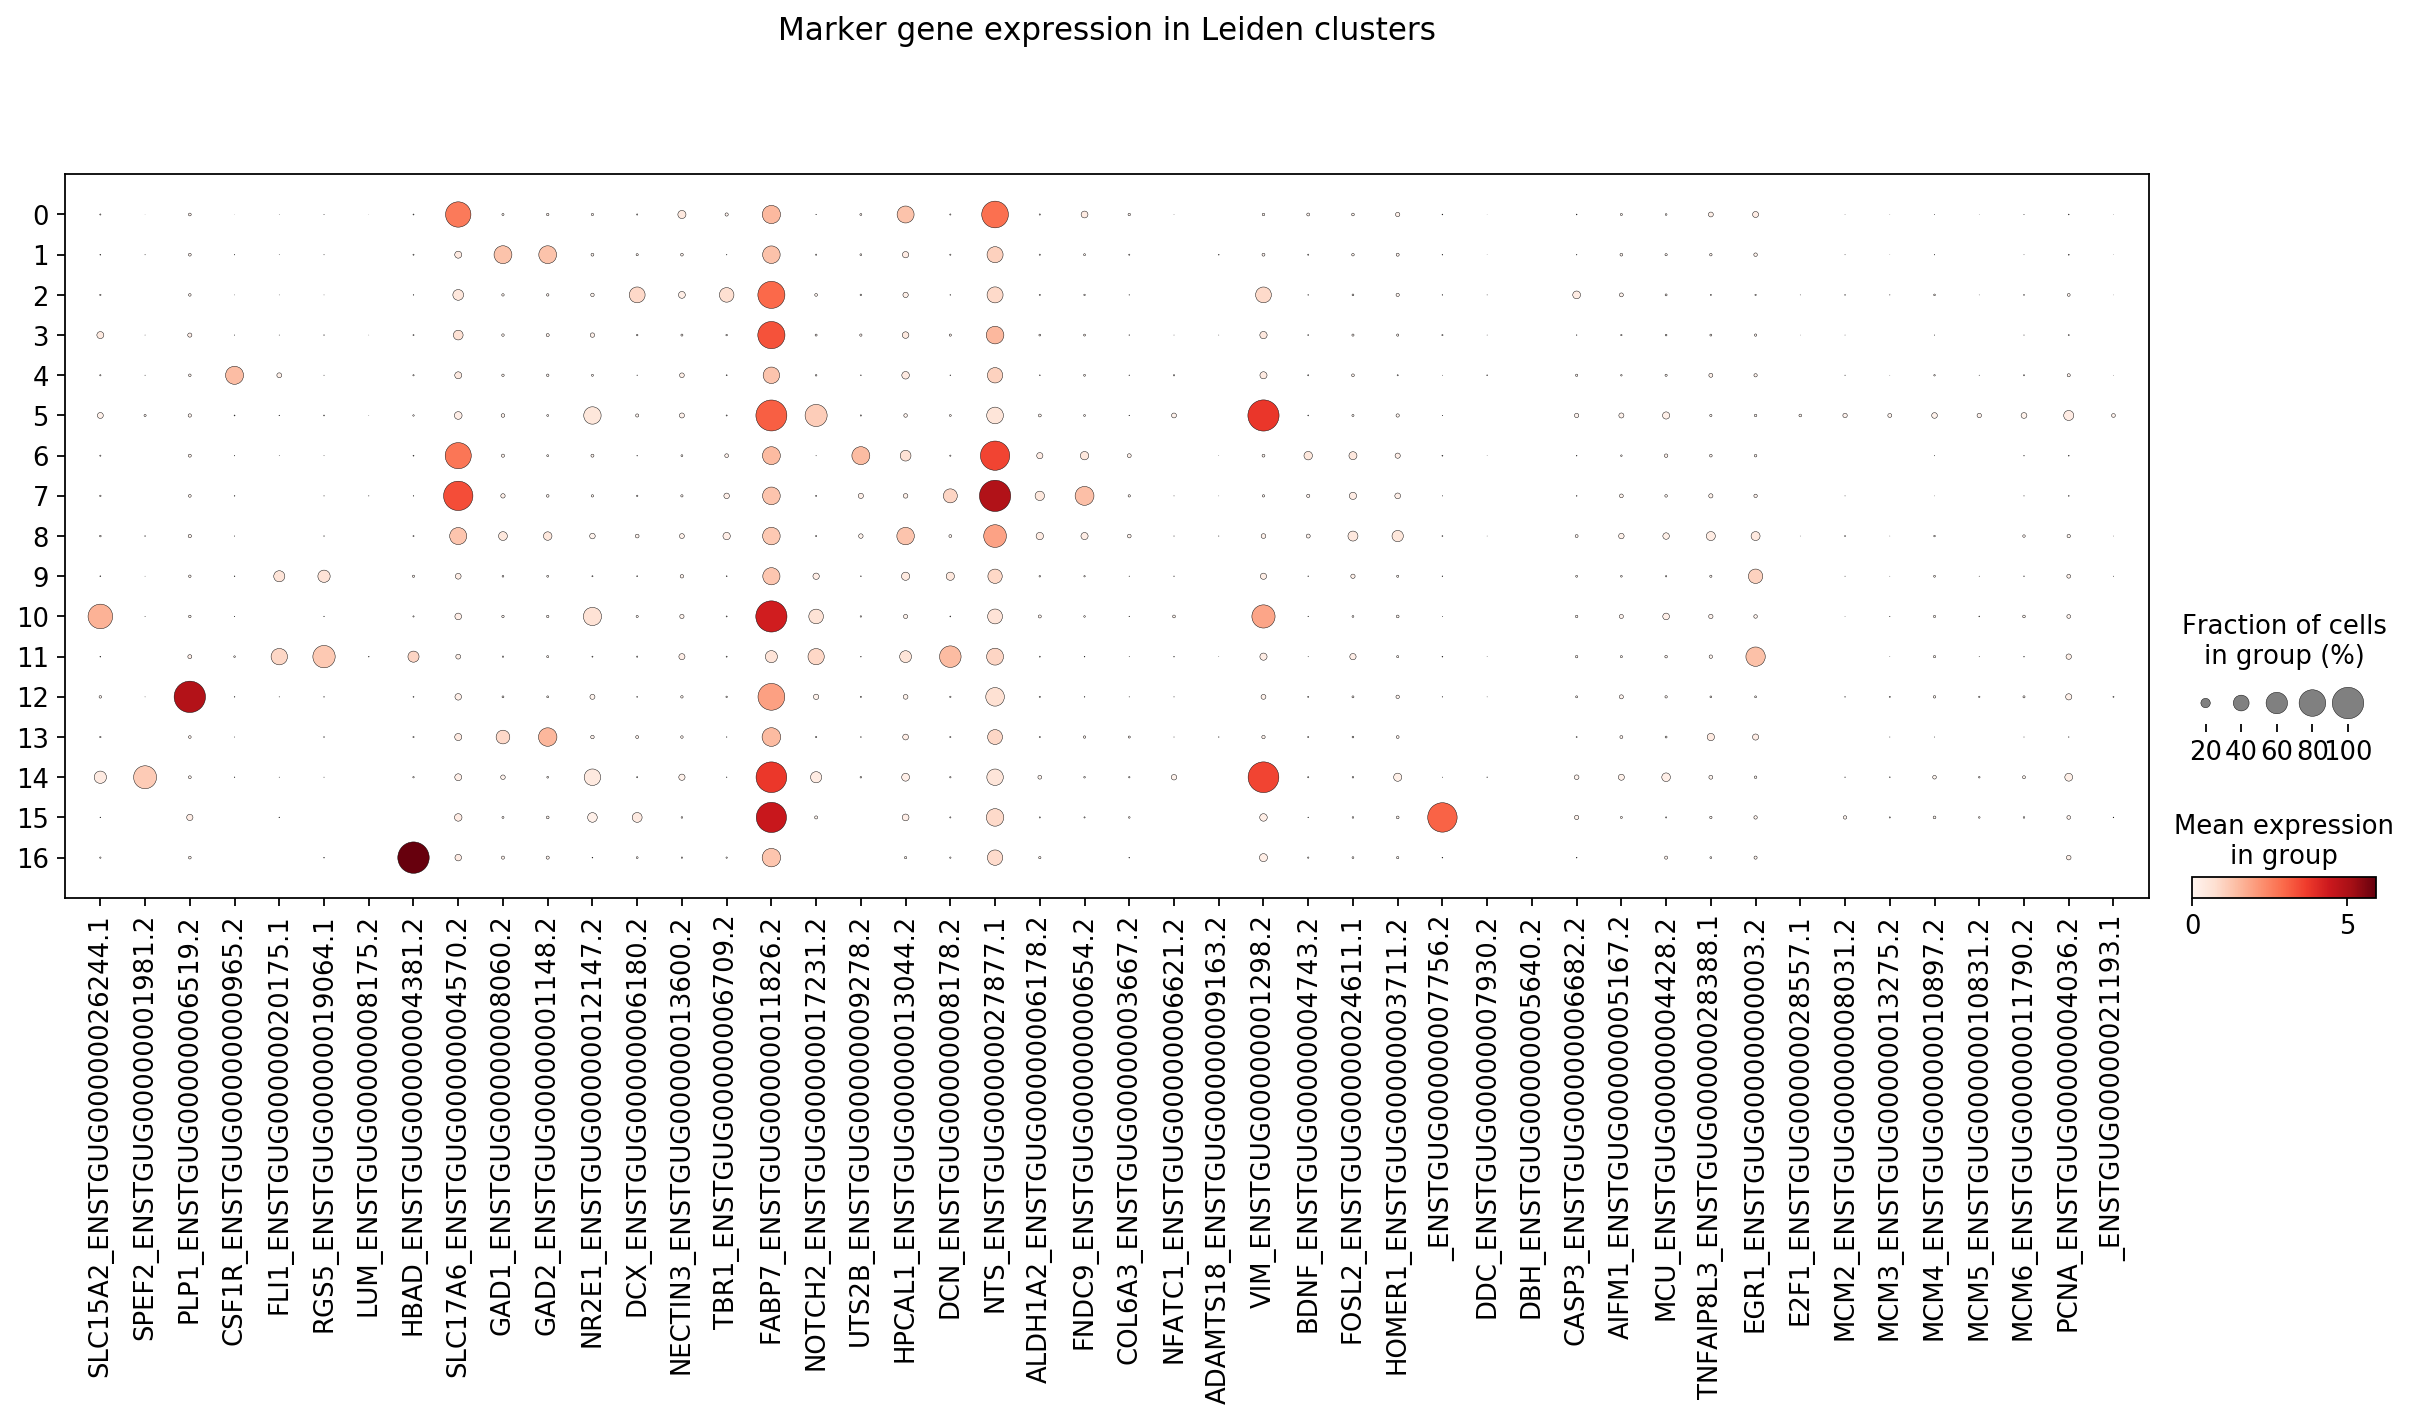

In [19]:
sc.pl.dotplot(
    adata,
    marker_gene_mat.index.values,
    groupby="leiden",
    title="Marker gene expression in Leiden clusters",
    use_raw=False
)

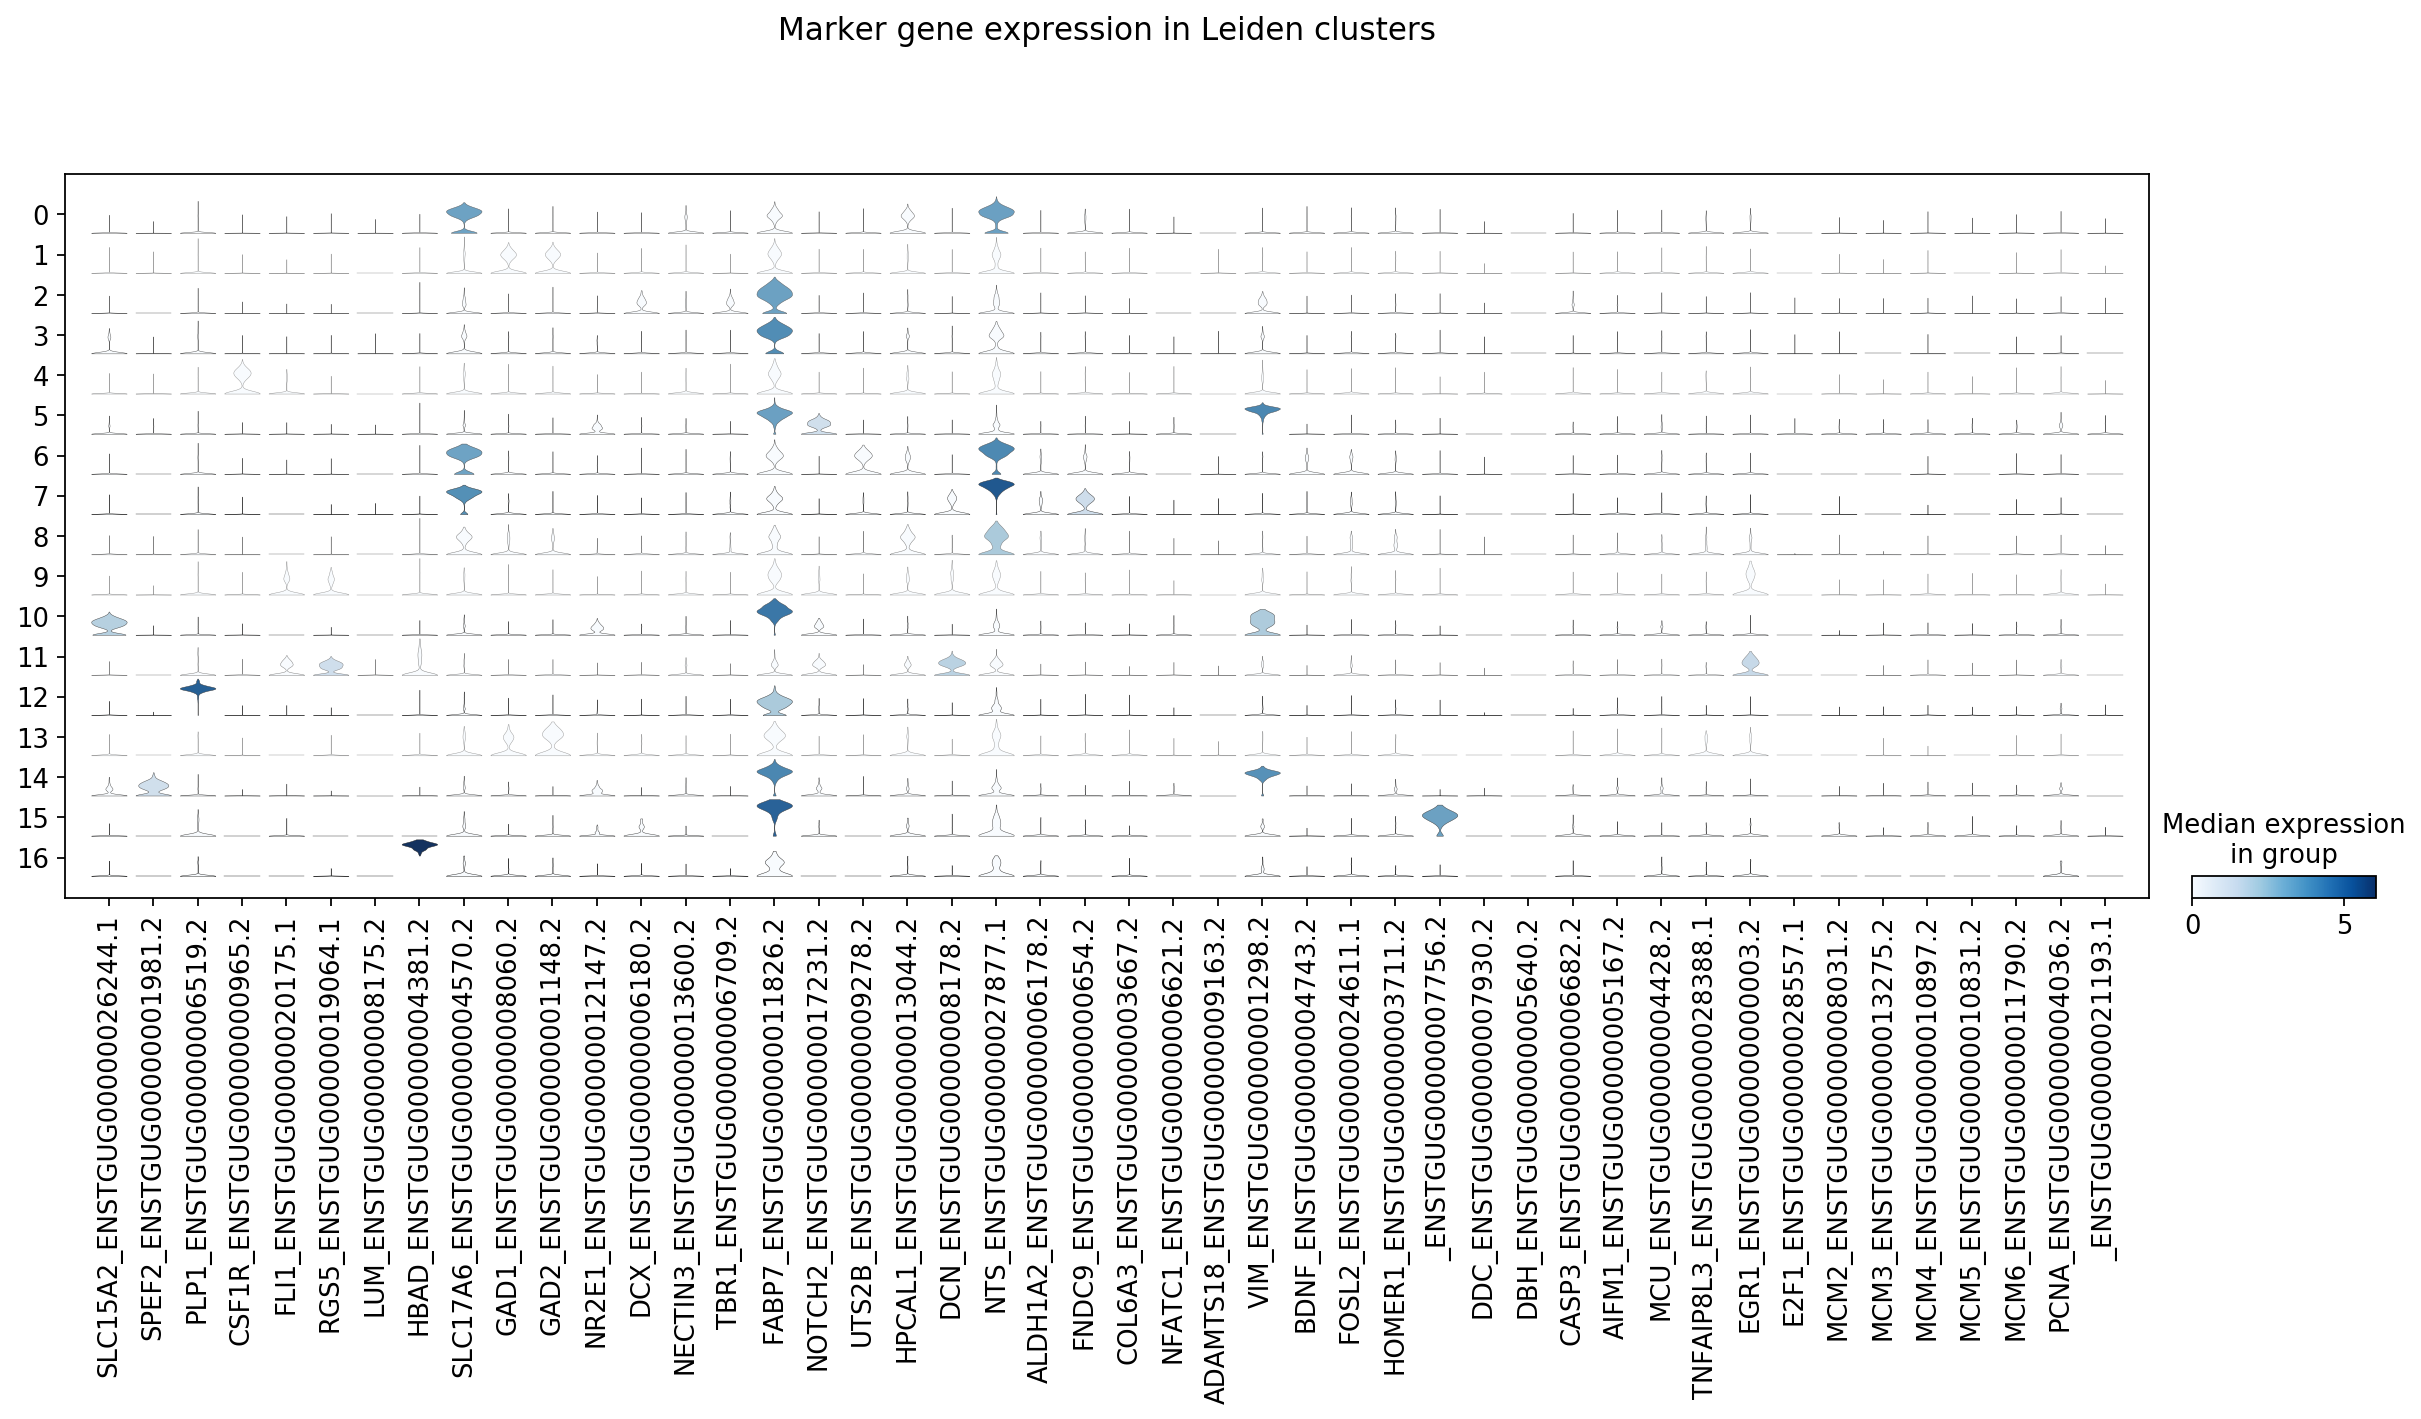

In [20]:
sc.pl.stacked_violin(adata, 
                     marker_gene_mat.index.values, 
                     groupby='leiden', 
                     title="Marker gene expression in Leiden clusters", 
                     rotation=90, 
                     sharey=True,
                     use_raw=False
                    )

# Run sc.tl.rank_genes_groups() using only marker genes

Remove all marker genes that do not specify a celltype (e.g. connecitivty (HVC-X, HVC-RA), mammalian neurogenesis, immediate early genes, etc.):

In [21]:
# Drop categories that I do not need for this analysis
marker_mat = marker_gene_mat.filter(["astrocytes", "ependymal cells", "oligodendrocytes", "oligodendrocyte precursor cells", "microglia", "radial glia", "vascular endothelial cells", "mural cells", "red blood cells", "leptomeningeal cells", "glutamatergic neurons", "GABAergic neurons", "dopaminergic neurons", "noradrenergic neurons", "GABAergic neuroblast", "adult neural stem cells", "migrating neuroblasts"], axis=1)
# Drop rows of genes containing only 0s
marker_mat = marker_mat.loc[(marker_mat!=0).any(axis=1)]

In [22]:
marker_mat

astrocytes  ependymal cells  oligodendrocytes  \
gene_name_id                                                                  
SLC15A2_ENSTGUG00000026244.1           1                0                 0   
SPEF2_ENSTGUG00000001981.2             0                1                 0   
PLP1_ENSTGUG00000006519.2              0                0                 1   
CSF1R_ENSTGUG00000000965.2             0                0                 0   
FLI1_ENSTGUG00000020175.1              0                0                 0   
RGS5_ENSTGUG00000019064.1              0                0                 0   
LUM_ENSTGUG00000008175.2               0                0                 0   
HBAD_ENSTGUG00000004381.2              0                0                 0   
SLC17A6_ENSTGUG00000004570.2           0                0                 0   
GAD1_ENSTGUG00000008060.2              0                0                 0   
GAD2_ENSTGUG00000001148.2              0                0                 0   
NR2E1_ENSTGUG00000012147.2             0                0                 0   
DCX_ENSTGUG00000006180.2               0                0                 0   
NECTIN3_ENSTGUG00000013600.2           0                0                 0   
VIM_ENSTGUG00000001298.2               0                0                 0   
_ENSTGUG00000007756.2                  0                0                 0   
DDC_ENSTGUG00000007930.2               0                0                 0   
DBH_ENSTGUG00000005640.2               0                0                 0   

                              oligodendrocyte precursor cells  microglia  \
gene_name_id                                                               
SLC15A2_ENSTGUG00000026244.1                                0          0   
SPEF2_ENSTGUG00000001981.2                                  0          0   
PLP1_ENSTGUG00000006519.2                                   0          0   
CSF1R_ENSTGUG00000000965.2                                  0          1   
FLI1_ENSTGUG00000020175.1                                   0          0   
RGS5_ENSTGUG00000019064.1                                   0          0   
LUM_ENSTGUG00000008175.2                                    0          0   
HBAD_ENSTGUG00000004381.2                                   0          0   
SLC17A6_ENSTGUG00000004570.2                                0          0   
GAD1_ENSTGUG00000008060.2                                   0          0   
GAD2_ENSTGUG00000001148.2                                   0          0   
NR2E1_ENSTGUG00000012147.2                                  0          0   
DCX_ENSTGUG00000006180.2                                    0          0   
NECTIN3_ENSTGUG00000013600.2                                0          0   
VIM_ENSTGUG00000001298.2                                    0          0   
_ENSTGUG00000007756.2                                       1          0   
DDC_ENSTGUG00000007930.2                                    0          0   
DBH_ENSTGUG00000005640.2                                    0          0   

                              radial glia  vascular endothelial cells  \
gene_name_id                                                            
SLC15A2_ENSTGUG00000026244.1            0                           0   
SPEF2_ENSTGUG00000001981.2              0                           0   
PLP1_ENSTGUG00000006519.2               0                           0   
CSF1R_ENSTGUG00000000965.2              0                           0   
FLI1_ENSTGUG00000020175.1               0                           1   
RGS5_ENSTGUG00000019064.1               0                           0   
LUM_ENSTGUG00000008175.2                0                           0   
HBAD_ENSTGUG00000004381.2               0                           0   
SLC17A6_ENSTGUG00000004570.2            0                           0   
GAD1_ENSTGUG00000008060.2               0                           0   
GAD2_ENSTGUG00000001148.2               0           

In [23]:
# Find indices of all marker genes in adata
ens_idx = np.isin(adata_test.var_names, marker_mat.index.values)

# Slice adata based on these indices
adata_test = adata_test[:,ens_idx].copy()
adata_test

AnnData object with n_obs × n_vars = 15810 × 18
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [24]:
adata_test.var

gene_name  highly_variable         means  \
DDC_ENSTGUG00000007930.2           DDC             True  1.376351e-02   
GAD2_ENSTGUG00000001148.2         GAD2             True  1.051390e+00   
VIM_ENSTGUG00000001298.2           VIM             True  1.984304e+00   
NECTIN3_ENSTGUG00000013600.2   NECTIN3             True  6.679075e-01   
NR2E1_ENSTGUG00000012147.2       NR2E1            False  3.245561e-01   
SPEF2_ENSTGUG00000001981.2       SPEF2            False  1.059927e-01   
_ENSTGUG00000007756.2                              True  3.654426e-01   
LUM_ENSTGUG00000008175.2           LUM            False  6.648030e-03   
SLC17A6_ENSTGUG00000004570.2   SLC17A6            False  2.542525e+00   
GAD1_ENSTGUG00000008060.2         GAD1             True  9.704400e-01   
SLC15A2_ENSTGUG00000026244.1   SLC15A2             True  5.748355e-01   
RGS5_ENSTGUG00000019064.1         RGS5            False  3.082190e-01   
DCX_ENSTGUG00000006180.2           DCX             True  4.552155e-01   
PLP1_ENSTGUG00000006519.2         PLP1             True  2.102049e+00   
CSF1R_ENSTGUG00000000965.2       CSF1R             True  5.838614e-01   
HBAD_ENSTGUG00000004381.2         HBAD             True  1.805144e+00   
DBH_ENSTGUG00000005640.2           DBH            False  1.000000e-12   
FLI1_ENSTGUG00000020175.1         FLI1             True  3.552347e-01   

                              dispersions  dispersions_norm  
DDC_ENSTGUG00000007930.2         2.638691          0.577231  
GAD2_ENSTGUG00000001148.2        3.372384          1.940951  
VIM_ENSTGUG00000001298.2         3.812140          1.415649  
NECTIN3_ENSTGUG00000013600.2     3.030409          1.473548  
NR2E1_ENSTGUG00000012147.2       2.046782         -2.844210  
SPEF2_ENSTGUG00000001981.2       2.391468          0.242145  
_ENSTGUG00000007756.2            3.954365          6.013226  
LUM_ENSTGUG00000008175.2         2.892977          0.921889  
SLC17A6_ENSTGUG00000004570.2     3.715499          0.460395  
GAD1_ENSTGUG00000008060.2        3.251130          1.547310  
SLC15A2_ENSTGUG00000026244.1     2.981331          1.244504  
RGS5_ENSTGUG00000019064.1        2.464217         -0.905946  
DCX_ENSTGUG00000006180.2         2.901276          1.123443  
PLP1_ENSTGUG00000006519.2        5.256342          4.310184  
CSF1R_ENSTGUG00000000965.2       3.518332          3.750625  
HBAD_ENSTGUG00000004381.2        6.207464          6.843421  
DBH_ENSTGUG00000005640.2              NaN          0.000000  
FLI1_ENSTGUG00000020175.1        2.867039          0.964467

In [25]:
sc.tl.rank_genes_groups(adata_test, groupby='leiden', method='t-test', corr_method="bonferroni", use_raw=False)

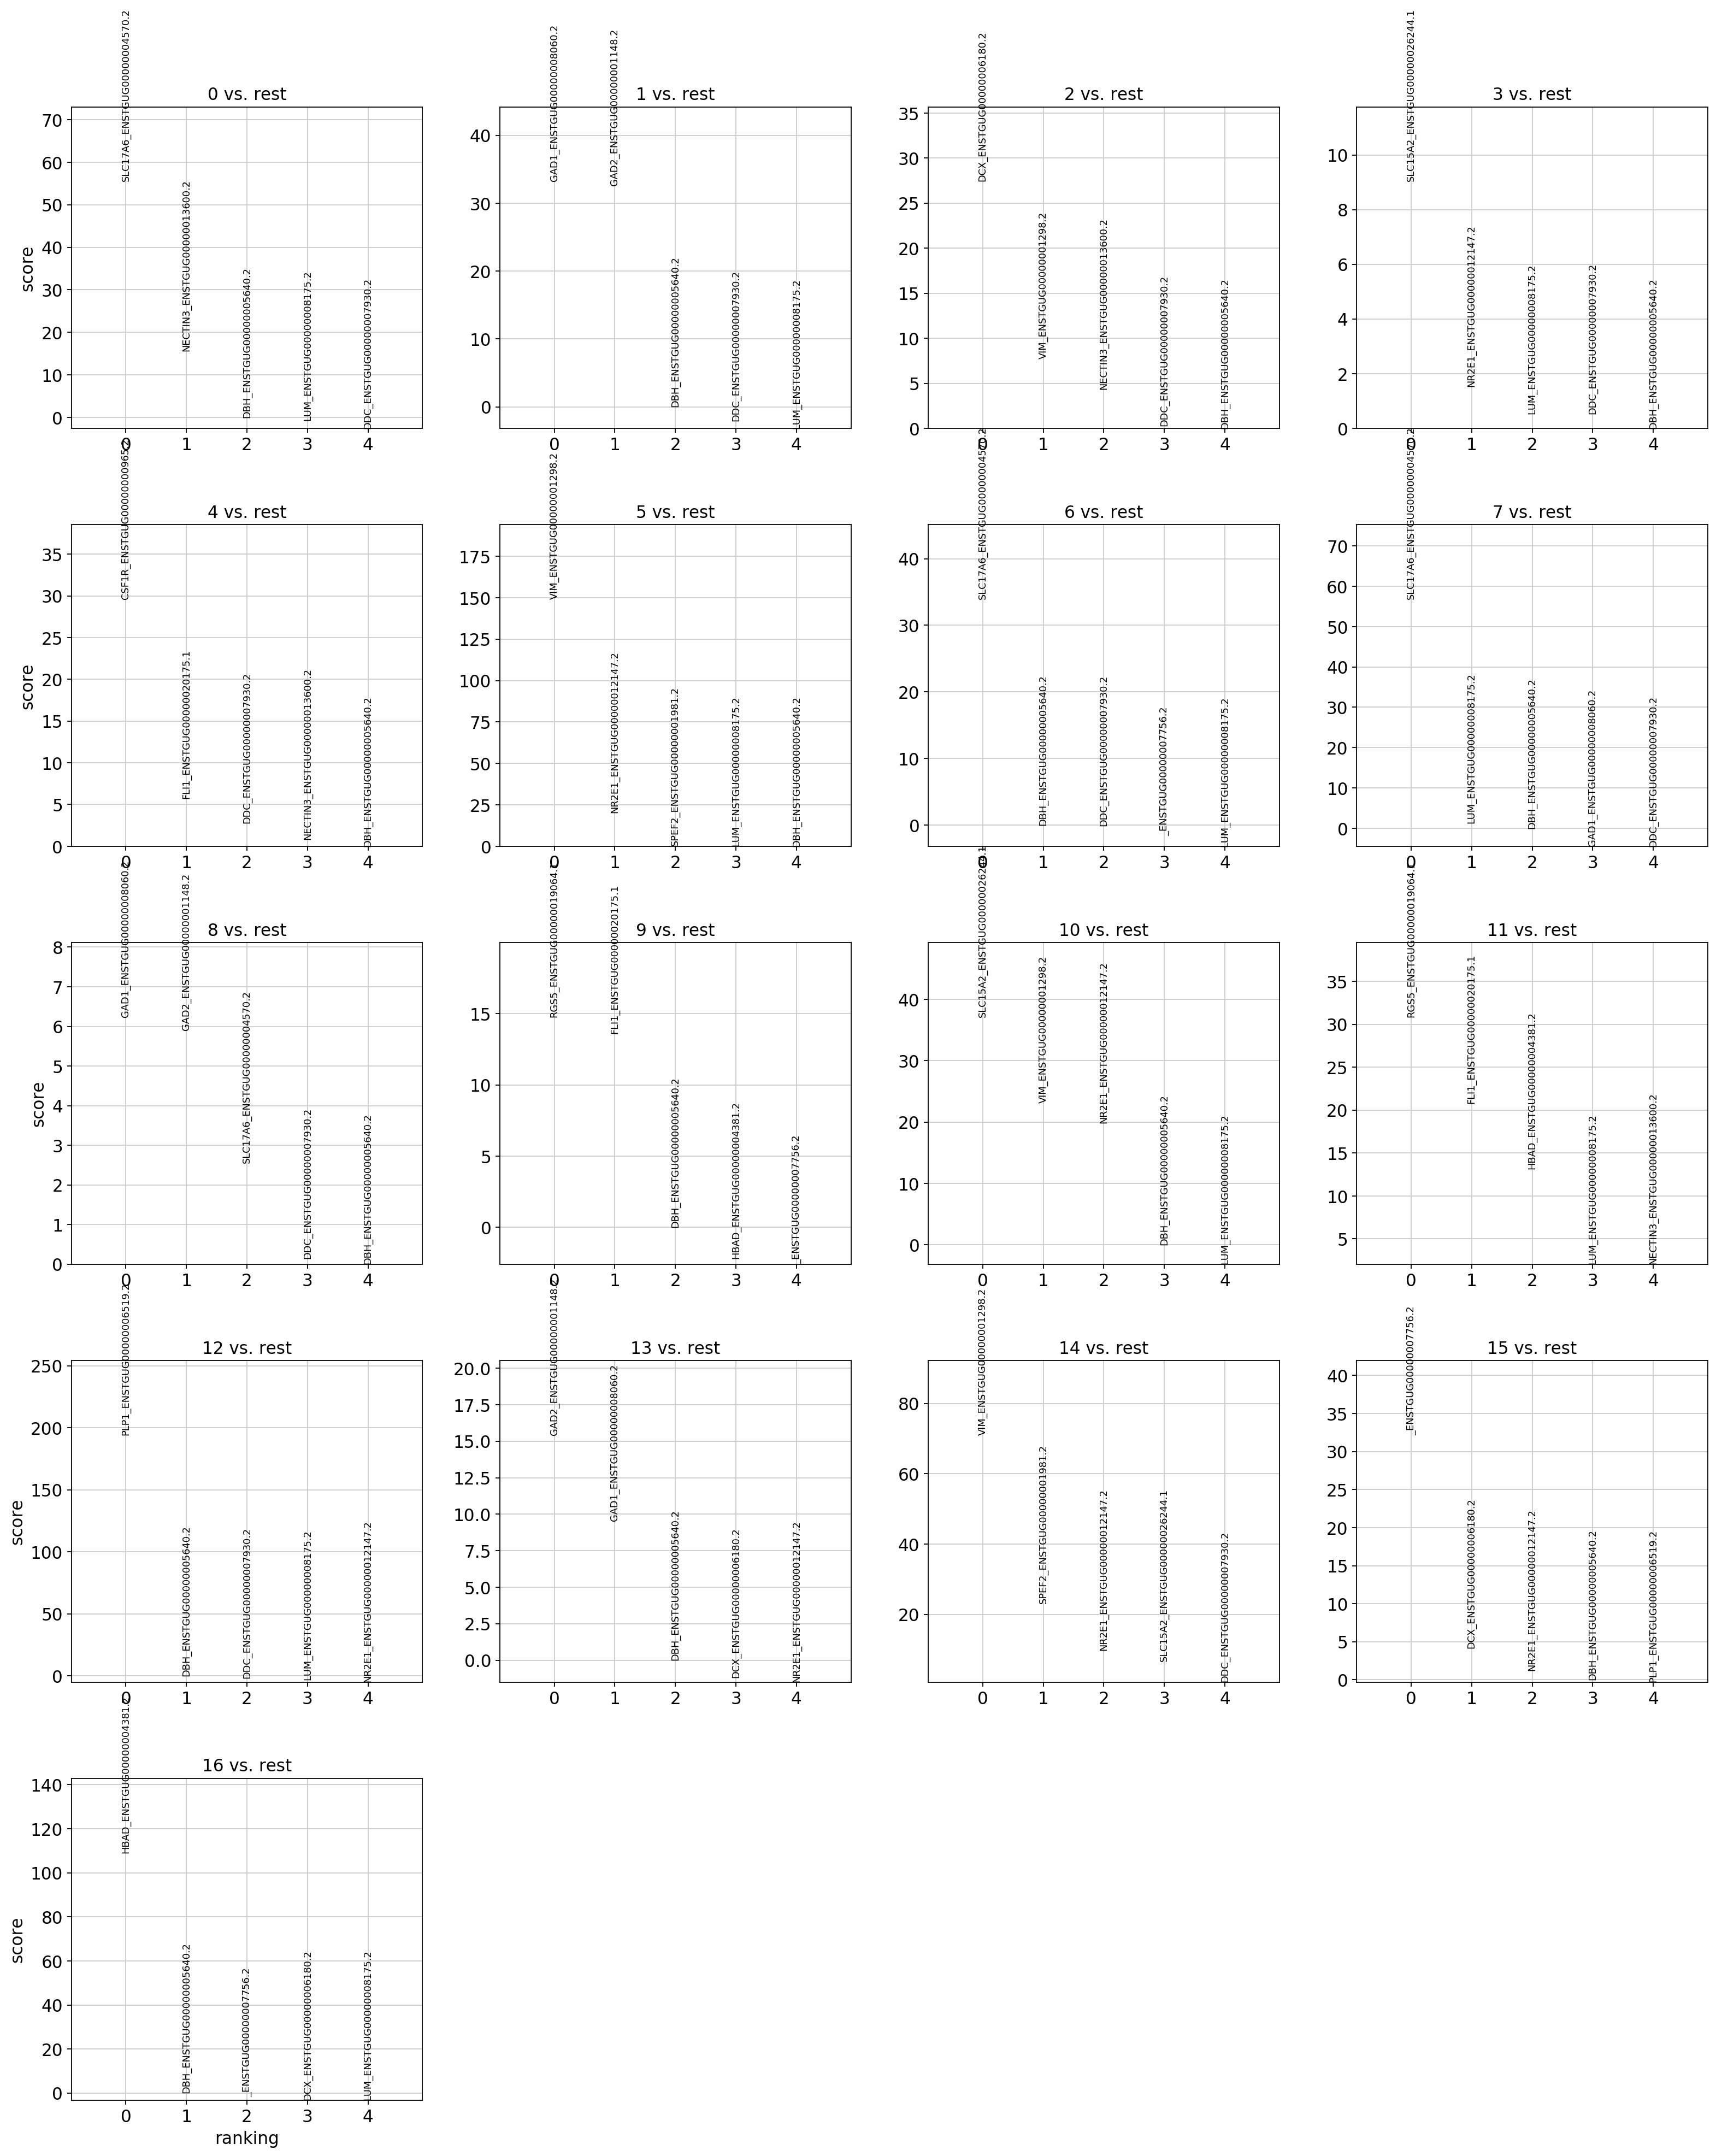

In [26]:
sc.pl.rank_genes_groups(adata_test, n_genes=5, sharey=False, save=False)

### Assign celltypes manually based on marker gene expression in each Leiden cluster

In [29]:
df_leiden = pd.DataFrame()
df_leiden["cluster"] = np.arange(17)
df_leiden["celltype"] = [
    "glutamatergic neurons 1",
    "GABAergic neurons 1",
    "migrating neuroblasts 1",
    "astrocytes 1",
    "microglia 1",
    "radial glia 1",
    "glutamatergic neurons 2",
    "glutamatergic neurons 3",
    "GABAergic neurons 2",
    "mural / vascular endothelial cells 1",
    "astrocytes 2",
    "mural cells 1",
    "oligodendrocytes 1",
    "GABAergic neurons 3",
    "radial glia 2",
    "oligodendrocyte precursor cells 1",
    "red blood cells 1"
]

df_leiden

cluster                            celltype
0         0             glutamatergic neurons 1
1         1                 GABAergic neurons 1
2         2               migrating neuroblasts
3         3                        astrocytes 1
4         4                           microglia
5         5                       radial glia 1
6         6             glutamatergic neurons 2
7         7             glutamatergic neurons 3
8         8                 GABAergic neurons 2
9         9  mural / vascular endothelial cells
10       10                        astrocytes 2
11       11                         mural cells
12       12                    oligodendrocytes
13       13                 GABAergic neurons 3
14       14                       radial glia 2
15       15     oligodendrocyte precursor cells
16       16                     red blood cells

___

# Add manually defined celltypes to AnnData object

In [30]:
# Create copy of leiden cluster column to store manually assigned celltypes
adata.obs["celltype"] = adata.obs.leiden.copy()

In [31]:
# Relabel the clusters in celltype
adata.rename_categories("celltype", df_leiden["celltype"].values)

In [32]:
adata.obs.head()

species     batch  n_counts_processed batch_index  \
barcode                                                                    
AAACCCAAGCACTGGA-0  zebrafinch  control1          483.000000           0   
AAACCCAAGCGTCAAG-0  zebrafinch  control1          946.000061           0   
AAACCCAAGGTCACAG-0  zebrafinch  control1         1068.000000           0   
AAACCCAAGTCATTGC-0  zebrafinch  control1         1407.000000           0   
AAACCCAAGTGCTACT-0  zebrafinch  control1         1060.000000           0   

                    n_counts_raw leiden             celltype  
barcode                                                       
AAACCCAAGCACTGGA-0    483.000000      3         astrocytes 1  
AAACCCAAGCGTCAAG-0    946.000061      4            microglia  
AAACCCAAGGTCACAG-0   1068.000000      1  GABAergic neurons 1  
AAACCCAAGTCATTGC-0   1407.000000     10         astrocytes 2  
AAACCCAAGTGCTACT-0   1060.000000      1  GABAergic neurons 1

___

# Celltype stats

Show number of cells for each celltype:

In [33]:
df_leiden["total number of cells"] = adata.obs.groupby("leiden").size().values.astype(int)
df_leiden = df_leiden.sort_values(["celltype"])

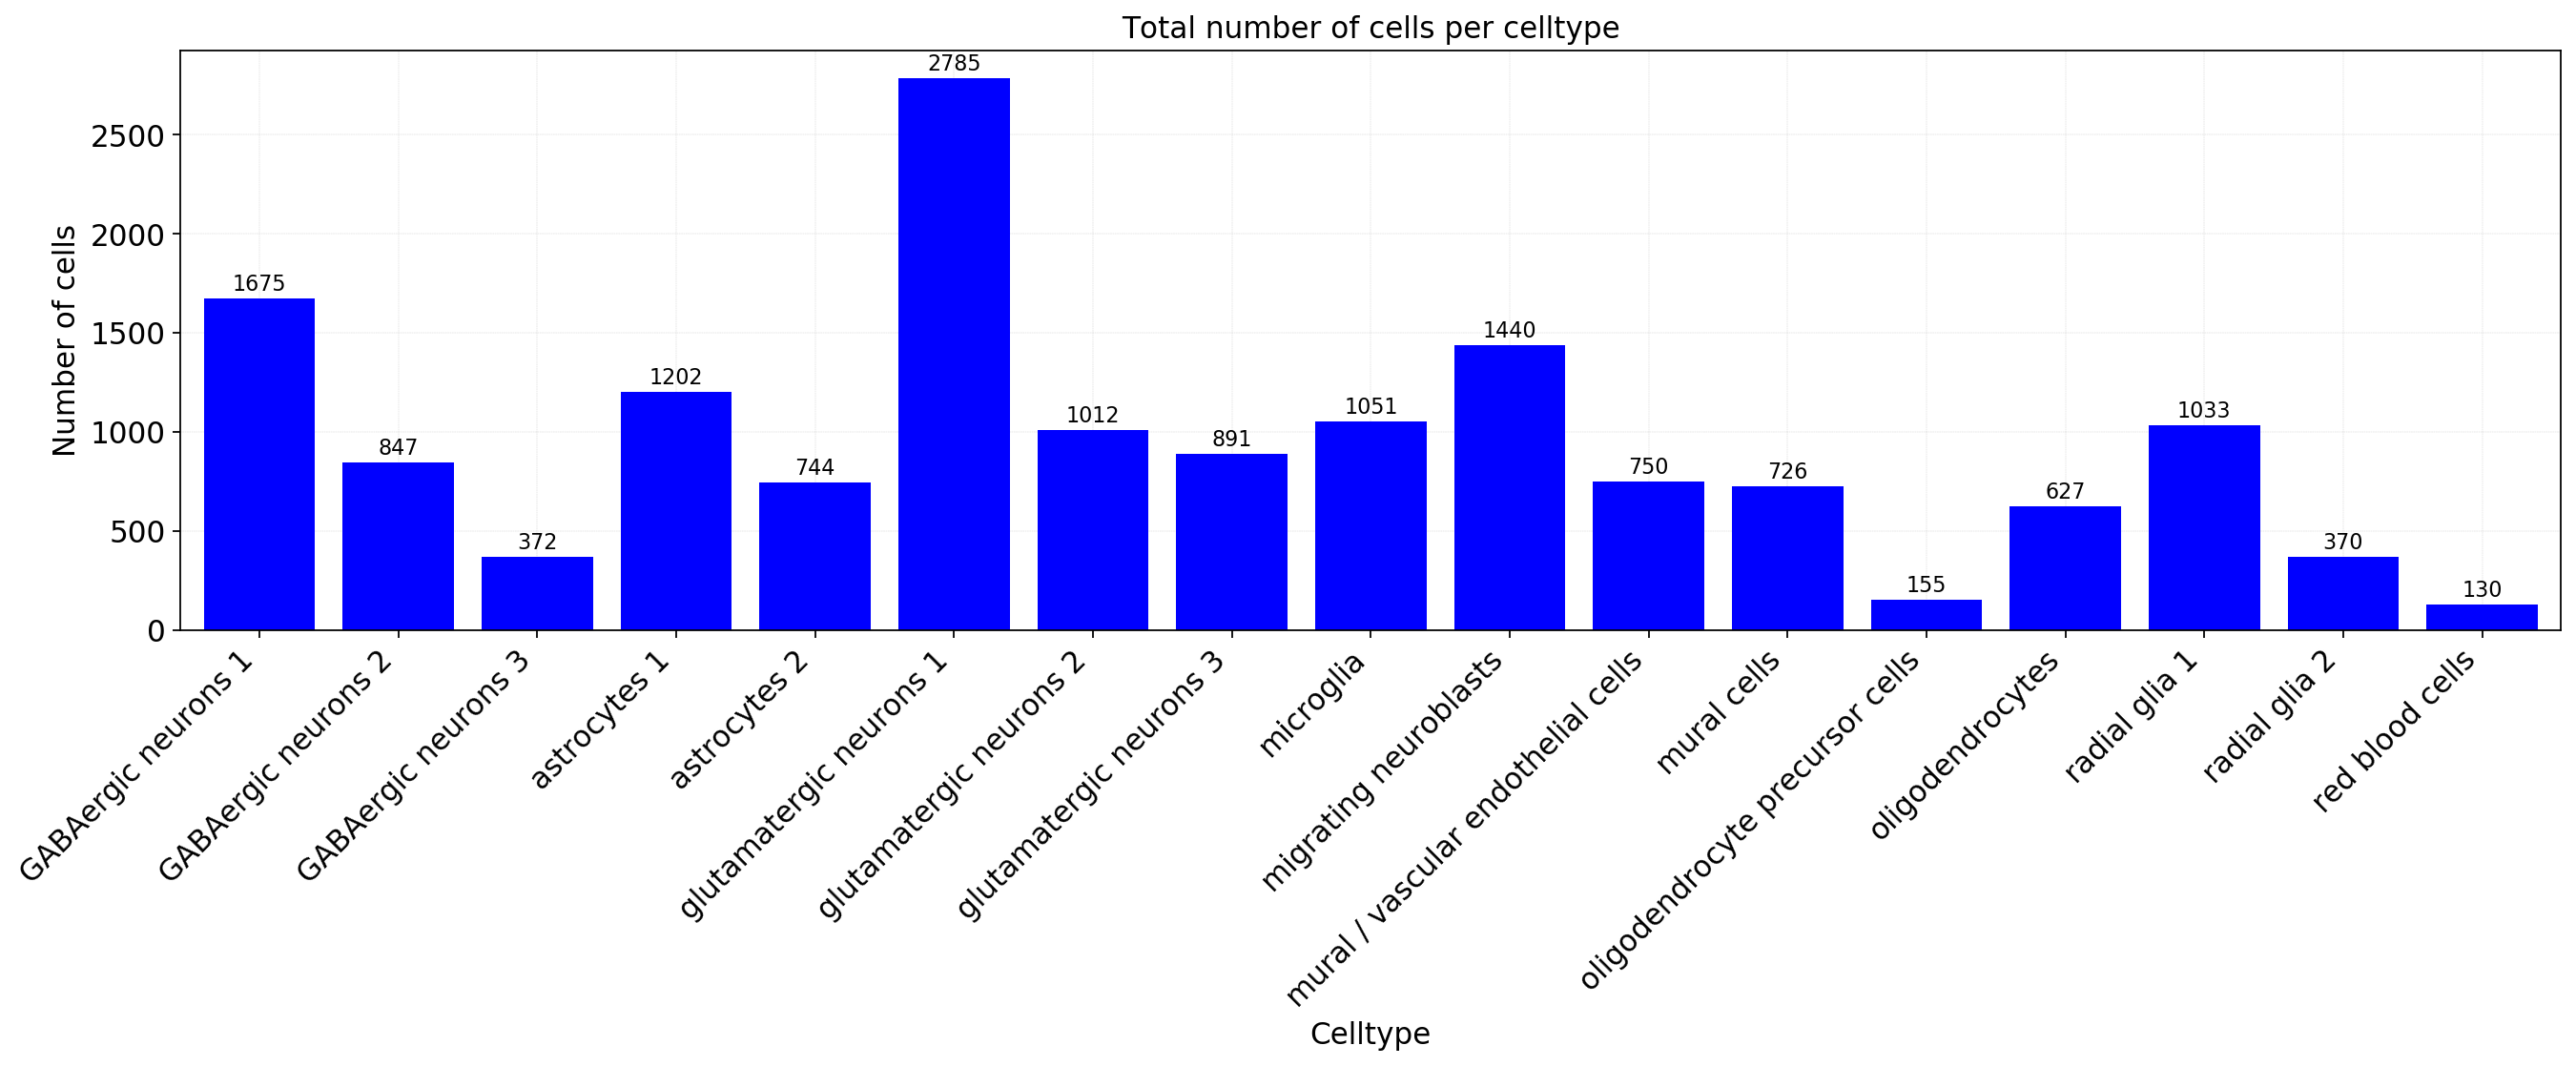

In [34]:
fig, ax = plt.subplots(figsize=(20,5))

clusters = df_leiden["celltype"].values
values = df_leiden["total number of cells"].values

ax.bar(clusters, values, color="blue")

# Add value above each bar
for index, value in enumerate(values):
    ax.text(x = index, y = value + 40, s = value, size = 10, ha='center')

ax.set_xticklabels(clusters, rotation = 45, ha="right")

ax.set(**{
    "title": "Total number of cells per celltype",
    "ylabel": "Number of cells",
    "xlabel": "Celltype"
})

ax.margins(x=0.01)
ax.grid(True, ls='--', lw=0.2)
ax.set_axisbelow(True)

fig.show()

### Plot UMAP with manually assigned celltypes:

In [35]:
# Desired order of the clusters
clusters = np.sort(df_leiden["celltype"].values)

# Reordering celltype labels using categorical data type
adata.obs["celltype"] = adata.obs["celltype"].cat.reorder_categories(list(clusters))

# Reordering leiden labels using categorical data type (so order is same as celltype labels)
adata.obs["leiden"] = adata.obs["leiden"].cat.reorder_categories(list(df_leiden["cluster"].values.astype(str)))

In [56]:
# Define cluster colors
palette = [
    "crimson",
    "coral",
    "orangered",
    "cornflowerblue",
    "darkblue",
    "yellowgreen",
    "seagreen",
    "darkgreen",
    "indigo", 
    "hotpink",
    "teal",
    "mediumturquoise",
    "gold",
    "darkorange",
    "orchid",
    "purple",
    "firebrick",
]

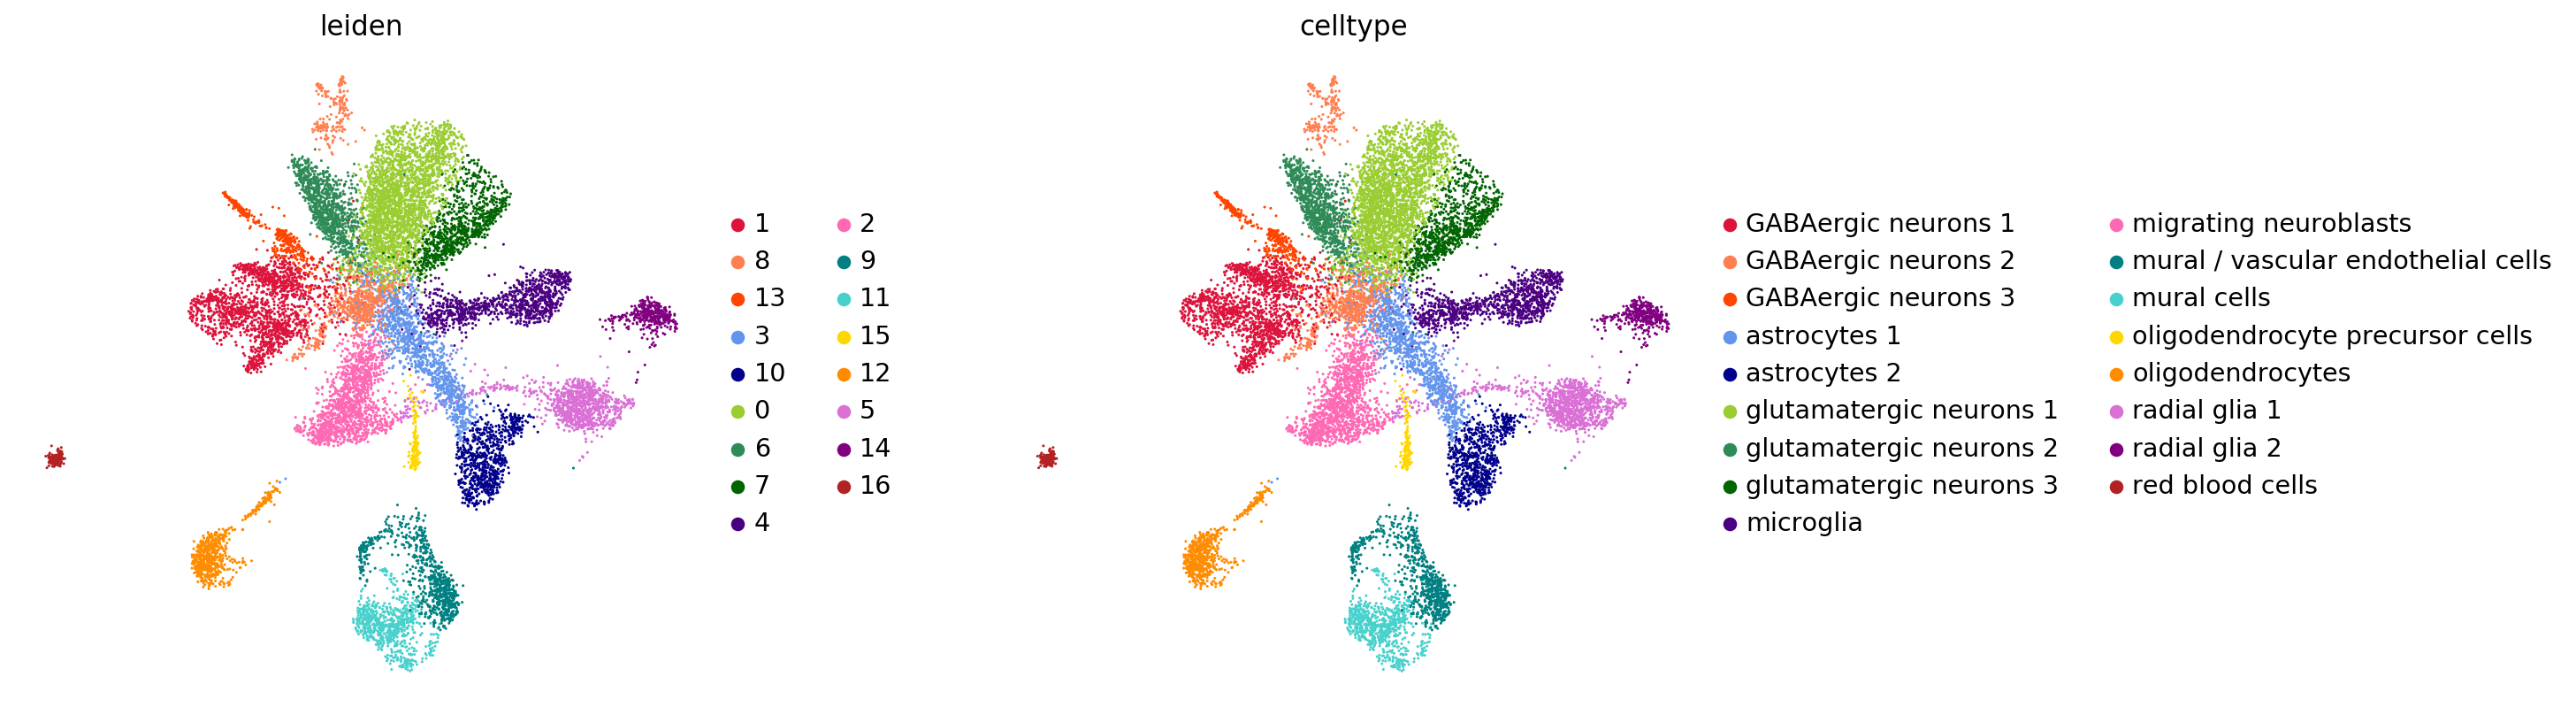

In [57]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata, 
           color=["leiden", "celltype"],
           palette=palette,
           wspace=0.3,
#            arrows=True,
#            projection="3d"
          )

___

# Heatmaps showing expression of known marker genes per celltype 

In [58]:
# Define markers in order of celltypes
markers = [
    "GAD1_ENSTGUG00000008060.2",
    "GAD2_ENSTGUG00000001148.2",
    "SLC15A2_ENSTGUG00000026244.1",
    "SLC17A6_ENSTGUG00000004570.2",
    "CSF1R_ENSTGUG00000000965.2",
    "DCX_ENSTGUG00000006180.2",
    "RGS5_ENSTGUG00000019064.1",
    "FLI1_ENSTGUG00000020175.1",
    "PLP1_ENSTGUG00000006519.2",
    "VIM_ENSTGUG00000001298.2",
    "HBAD_ENSTGUG00000004381.2",
#     "SPEF2_ENSTGUG00000001981.2",
#     "LUM_ENSTGUG00000008175.2",
#     "DDC_ENSTGUG00000007930.2",
#     "DBH_ENSTGUG00000005640.2",
#     "NR2E1_ENSTGUG00000012147.2",
#     "NECTIN3_ENSTGUG00000013600.2",
]

# Define marker groups
var_groups = [
    (0, 1),
    (2, 2),
    (3, 3),
    (4, 4),
    (5, 5),
    (6, 6),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
#     (11, 11),
#     (12, 12),
#     (13, 13),
#     (14, 14),
#     (15, 15),
#     (16, 16),
]

# Define marker group labels
var_labels = [
    "GABAergic neurons",
    "astrocytes",
    "glutamatergic neurons",
    "microglia",
    "migrating neuroblasts",
    "mural cells",
    "vascular endothelial cells",
    "oligodendrocytes",
    "radial glia",
    "red blood cells",
#     "ependymal cells",
#     "leptomeningeal cells",
#     "dopaminergic neurons",
#     "noradrenergic neurons",
#     "adult neural stem cells",
#     "GABAergic neuroblast",
]

Heatmap showing expression of previously known marker genes:

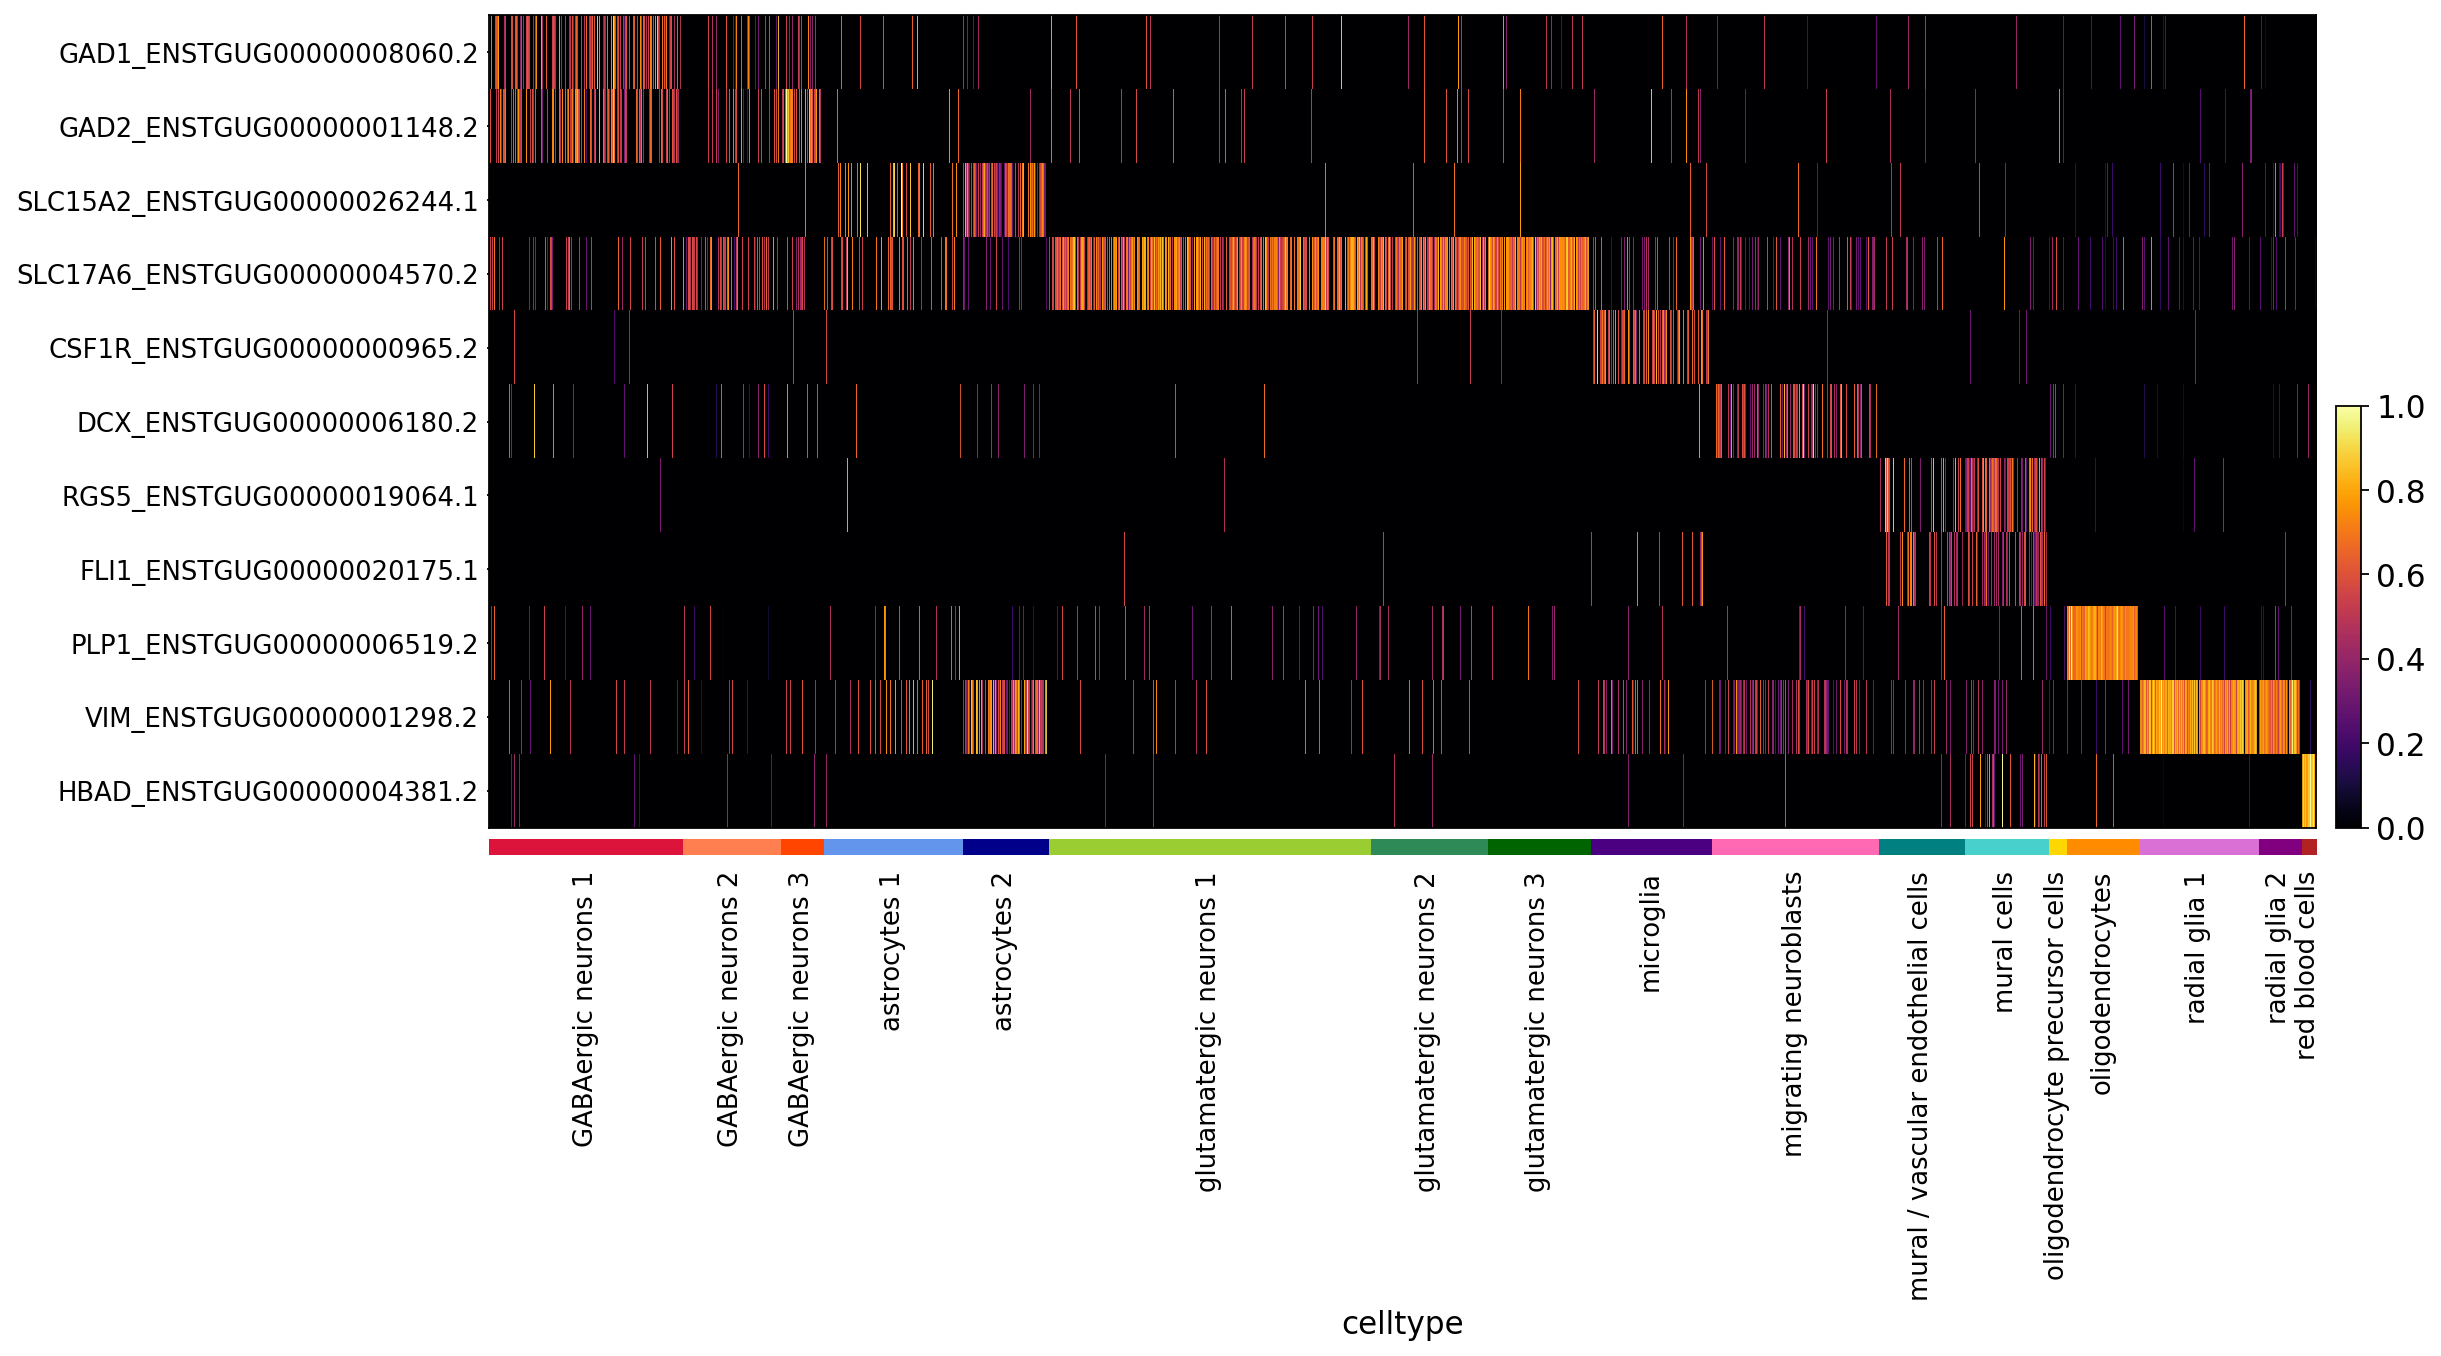

In [59]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="celltype",
#     dendrogram=True, # This messes up the ordering of the celltypes
    show_gene_labels=True,
#     var_group_positions=var_groups,
#     var_group_labels=var_labels,
#     var_group_rotation=1,
    use_raw=False, # By default adata.raw.X is plotted. If use_raw=False is set, then adata.X is plotted. 
    cmap="inferno", # Alternative cmap: magma
    standard_scale="var", # standardize that dimension between 0 and 1, meaning for each variable or observation, subtract the minimum and divide each by its maximum
    swap_axes=True,
    figsize=(15, 7)
)

___

# Assign connectivity (HVC-X / HVC-RA) to glutamatergic neurons

In [60]:
# Drop categories that I do not need for this analysis
conn_mat = marker_gene_mat.filter(["HVC-RA", "HVC-X"], axis=1)
# Drop rows of genes containing only 0s
conn_mat = conn_mat.loc[(conn_mat!=0).any(axis=1)]
conn_mat

HVC-RA  HVC-X
gene_name_id                               
UTS2B_ENSTGUG00000009278.2         1      0
HPCAL1_ENSTGUG00000013044.2        1      0
DCN_ENSTGUG00000008178.2           0      1
NTS_ENSTGUG00000027877.1           0      1
ALDH1A2_ENSTGUG00000006178.2       0      1
FNDC9_ENSTGUG00000000654.2         0      1

In [61]:
# Find indices of all marker genes in adata
ens_idx = np.isin(adata.var_names, conn_mat.index.values)

# Slice adata based on these indices
adata_conn = adata[:,ens_idx].copy()

# Remove all celltypes but glutamatergic neurons
adata_conn = adata_conn[np.char.startswith(nd(adata_conn.obs.celltype.values).astype(str), "glutamatergic neurons")]

adata_conn

View of AnnData object with n_obs × n_vars = 4688 × 6
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'celltype_colors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [62]:
sc.tl.rank_genes_groups(adata_conn, groupby='celltype', method='t-test', corr_method="bonferroni", use_raw=False)

Trying to set attribute `.uns` of view, copying.


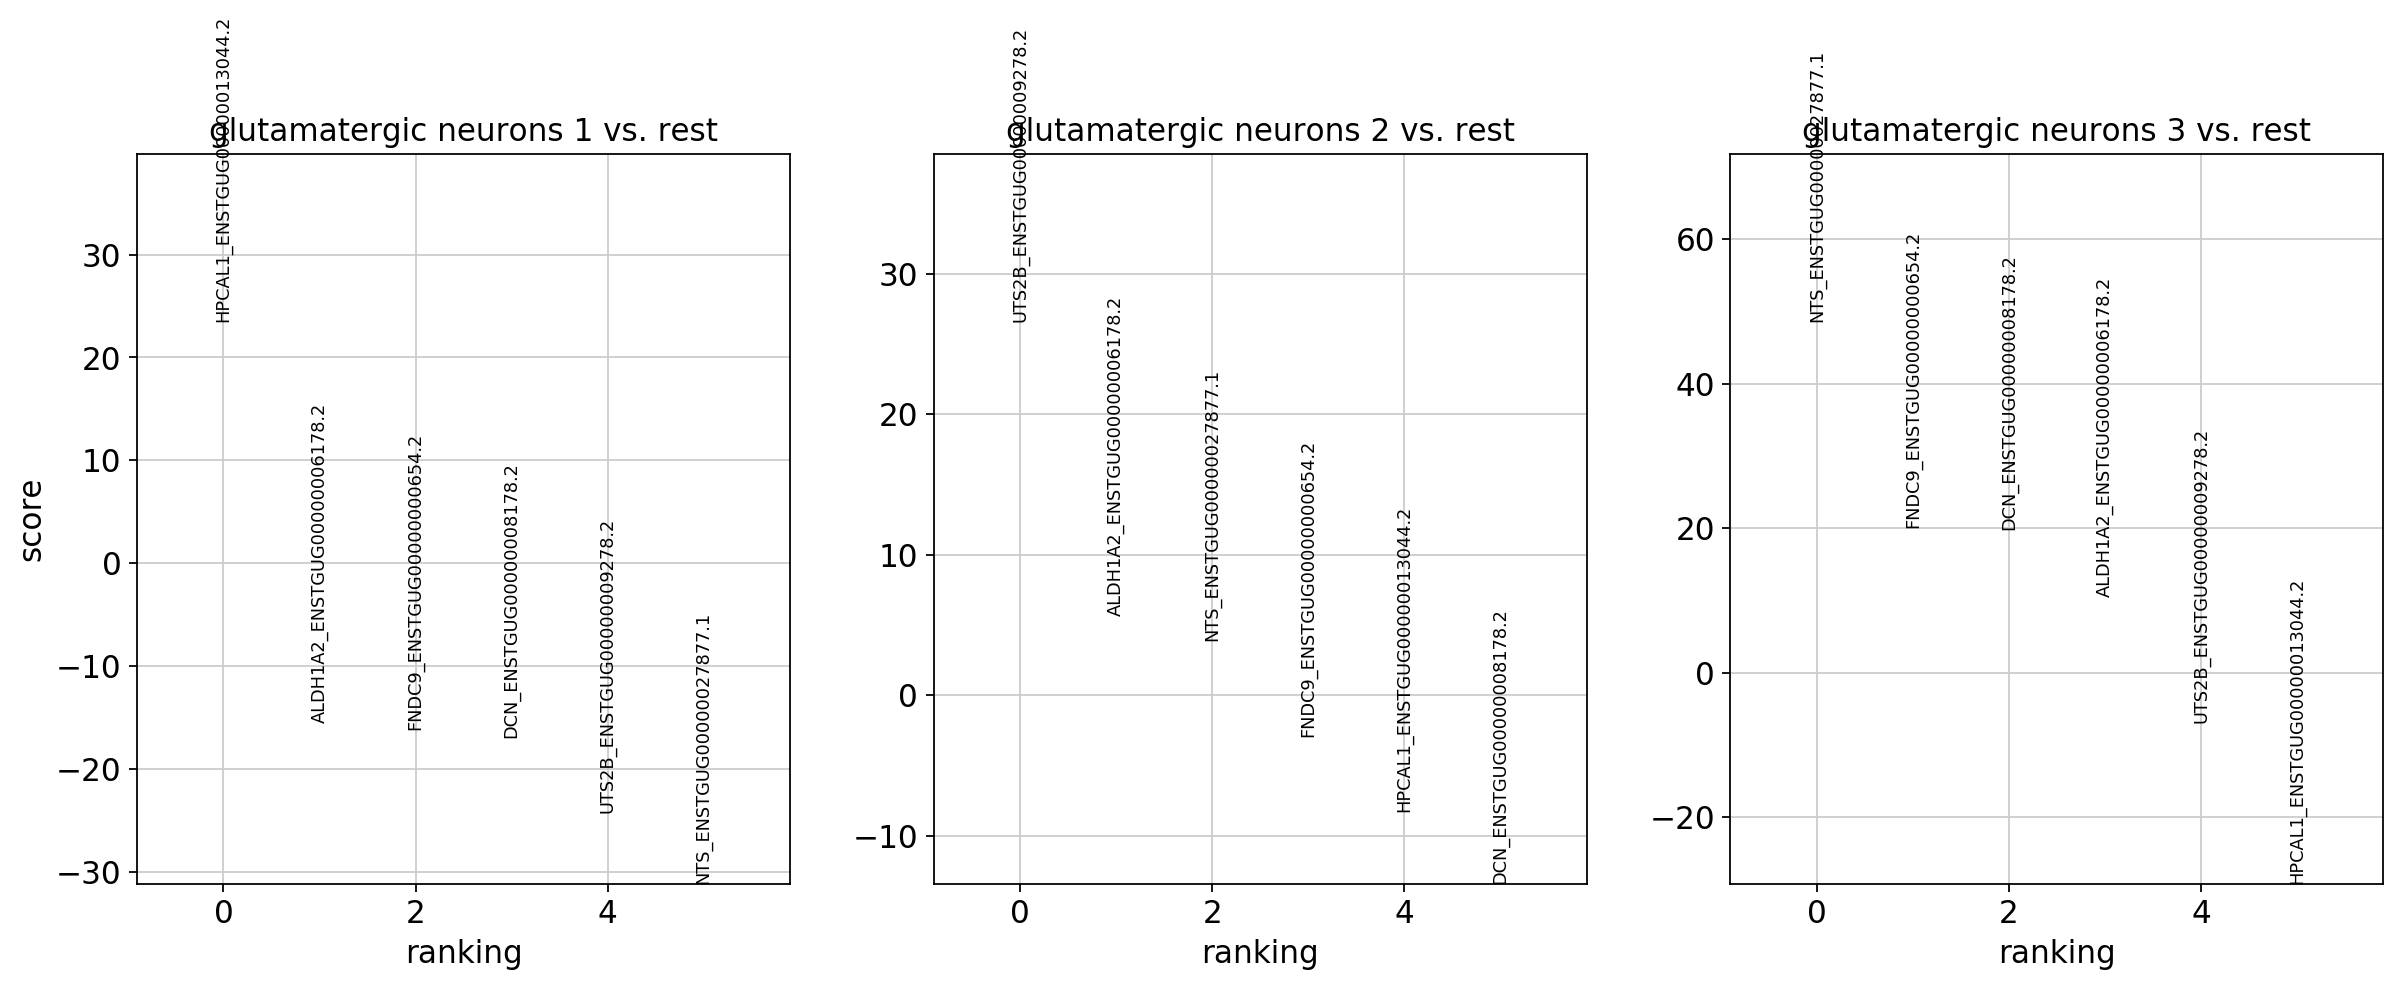

In [63]:
sc.pl.rank_genes_groups(adata_conn, n_genes=6, sharey=False, save=False, ncols=5)

Add assigned connectivity to adata.obs:

In [72]:
# Create copy of leiden cluster column to store manually assigned connectivity
adata.obs["connectivity"] = adata.obs.celltype.copy()

In [73]:
celltypes = nd(adata.obs.celltype.unique())
celltypes

df_connectivity = pd.DataFrame()
df_connectivity["celltypes"] = celltypes
# Using a range of numbers here, otherwise the rename_categories function will not work
df_connectivity["connectivity"] = np.arange(len(celltypes))

# Assign connectivity
df_connectivity["connectivity"][df_connectivity["celltypes"]=="glutamatergic neurons 1"] = "undefined"
df_connectivity["connectivity"][df_connectivity["celltypes"]=="glutamatergic neurons 2"] = "HVC-RA"
df_connectivity["connectivity"][df_connectivity["celltypes"]=="glutamatergic neurons 3"] = "HVC-X"

# Sort by celltypes (otherwise rename categories does not work correctly)
df_connectivity = df_connectivity.sort_values("celltypes")
df_connectivity

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


celltypes connectivity
2                  GABAergic neurons 1            2
9                  GABAergic neurons 2            9
7                  GABAergic neurons 3            7
0                         astrocytes 1            0
3                         astrocytes 2            3
6              glutamatergic neurons 1    undefined
10             glutamatergic neurons 2       HVC-RA
12             glutamatergic neurons 3        HVC-X
1                            microglia            1
8                migrating neuroblasts            8
13  mural / vascular endothelial cells           13
5                          mural cells            5
15     oligodendrocyte precursor cells           15
14                    oligodendrocytes           14
11                       radial glia 1           11
16                       radial glia 2           16
4                      red blood cells            4

In [74]:
adata.rename_categories("connectivity", df_connectivity["connectivity"].values)

In [75]:
adata.obs.head()

species     batch  n_counts_processed batch_index  \
barcode                                                                    
AAACCCAAGCACTGGA-0  zebrafinch  control1          483.000000           0   
AAACCCAAGCGTCAAG-0  zebrafinch  control1          946.000061           0   
AAACCCAAGGTCACAG-0  zebrafinch  control1         1068.000000           0   
AAACCCAAGTCATTGC-0  zebrafinch  control1         1407.000000           0   
AAACCCAAGTGCTACT-0  zebrafinch  control1         1060.000000           0   

                    n_counts_raw leiden             celltype connectivity  
barcode                                                                    
AAACCCAAGCACTGGA-0    483.000000      3         astrocytes 1            0  
AAACCCAAGCGTCAAG-0    946.000061      4            microglia            1  
AAACCCAAGGTCACAG-0   1068.000000      1  GABAergic neurons 1            2  
AAACCCAAGTCATTGC-0   1407.000000     10         astrocytes 2            3  
AAACCCAAGTGCTACT-0   1060.000000      1  GABAergic neurons 1            2

### Plot glutamatergic neuron connectivity assignment

In [78]:
# Desired order of the connectivity clusters
conn_clusters = ["HVC-RA", "HVC-X", "undefined", 2, 9, 7, 0, 3, 1, 8, 13, 5, 15, 14, 11, 16, 4]

# Reordering connectivity labels using categorical data type
adata.obs["connectivity"] = adata.obs["connectivity"].cat.reorder_categories(list(conn_clusters))

In [79]:
palette_glut = [
    "crimson",
    "indigo",
    "orchid",
    "pink"
]

All celltypes for reference:

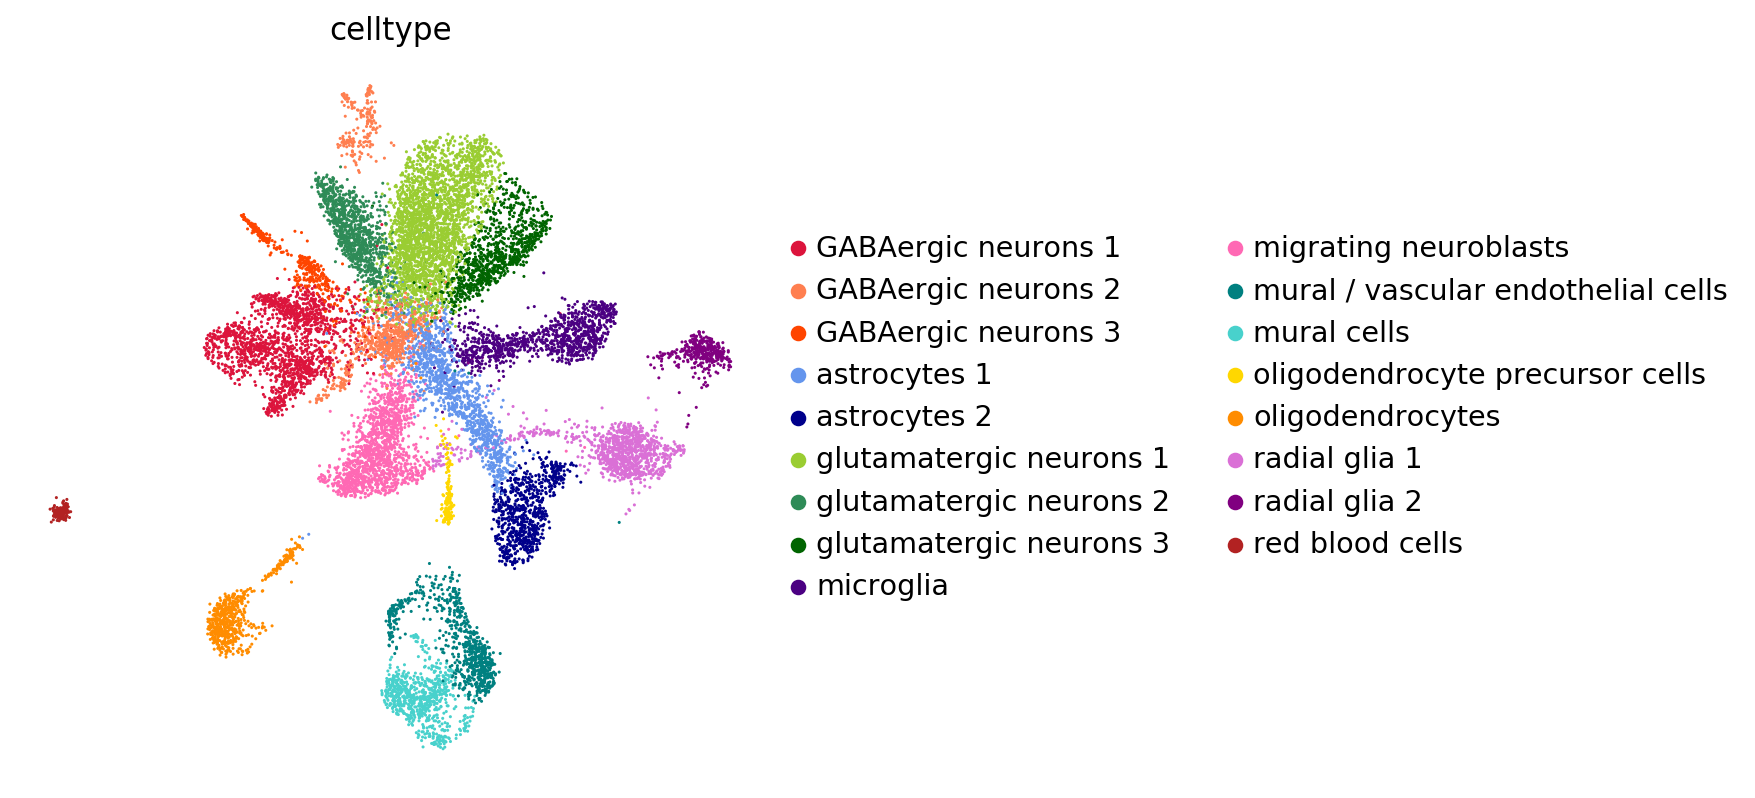

In [80]:
sc.pl.umap(
    adata,
    color=["celltype"],
    ncols=1
)

Connectivity:

Trying to set attribute `.uns` of view, copying.


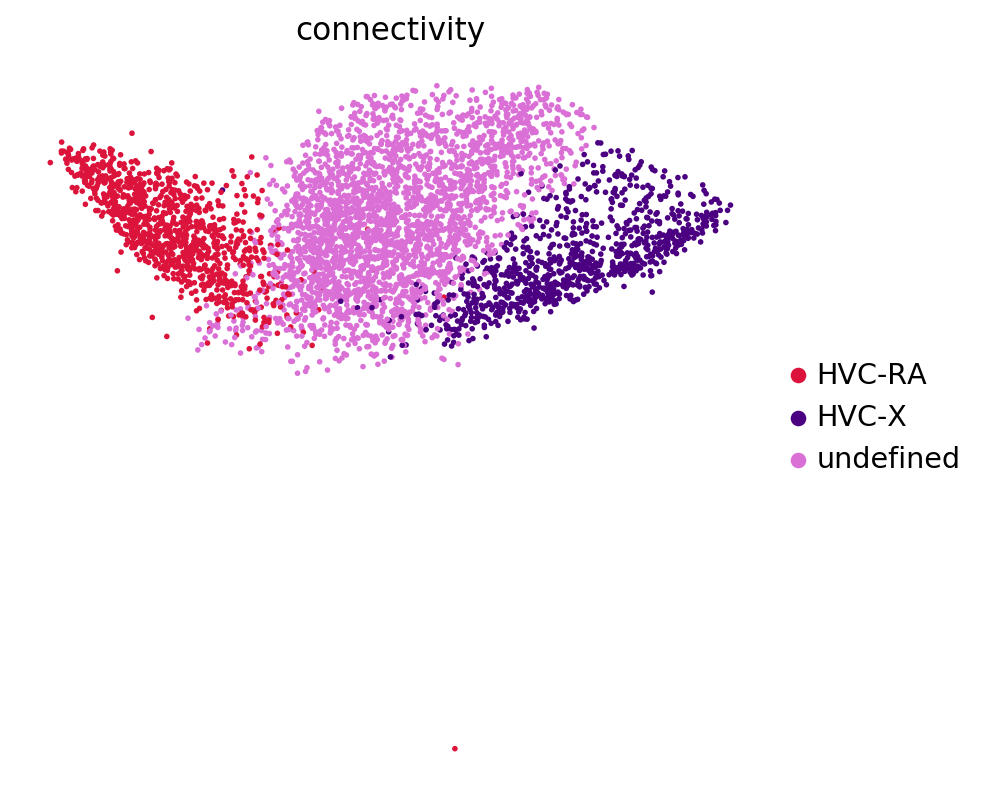

In [81]:
sc.pl.umap(
    adata[np.char.startswith(nd(adata.obs.celltype.values).astype(str), "glutamatergic neurons")],
    color=["connectivity"],
    palette=palette_glut,
    ncols=1
)

This assignment makes sense given that WRE is expressed mostly in WRE (see graph below of WRE expression). We do not know why AAVs target HVC-X more succesfully than HVC-RA neurons, but this coincides with what we previouly observed in the lab based on overlap between viral fluorophore expression and tracers from RA or from X.

In [82]:
markers = [
    "UTS2B_ENSTGUG00000009278.2",
    "HPCAL1_ENSTGUG00000013044.2",
    "ALDH1A2_ENSTGUG00000006178.2",
    "DCN_ENSTGUG00000008178.2",
    "FNDC9_ENSTGUG00000000654.2",
    "NTS_ENSTGUG00000027877.1",
]

Trying to set attribute `.uns` of view, copying.


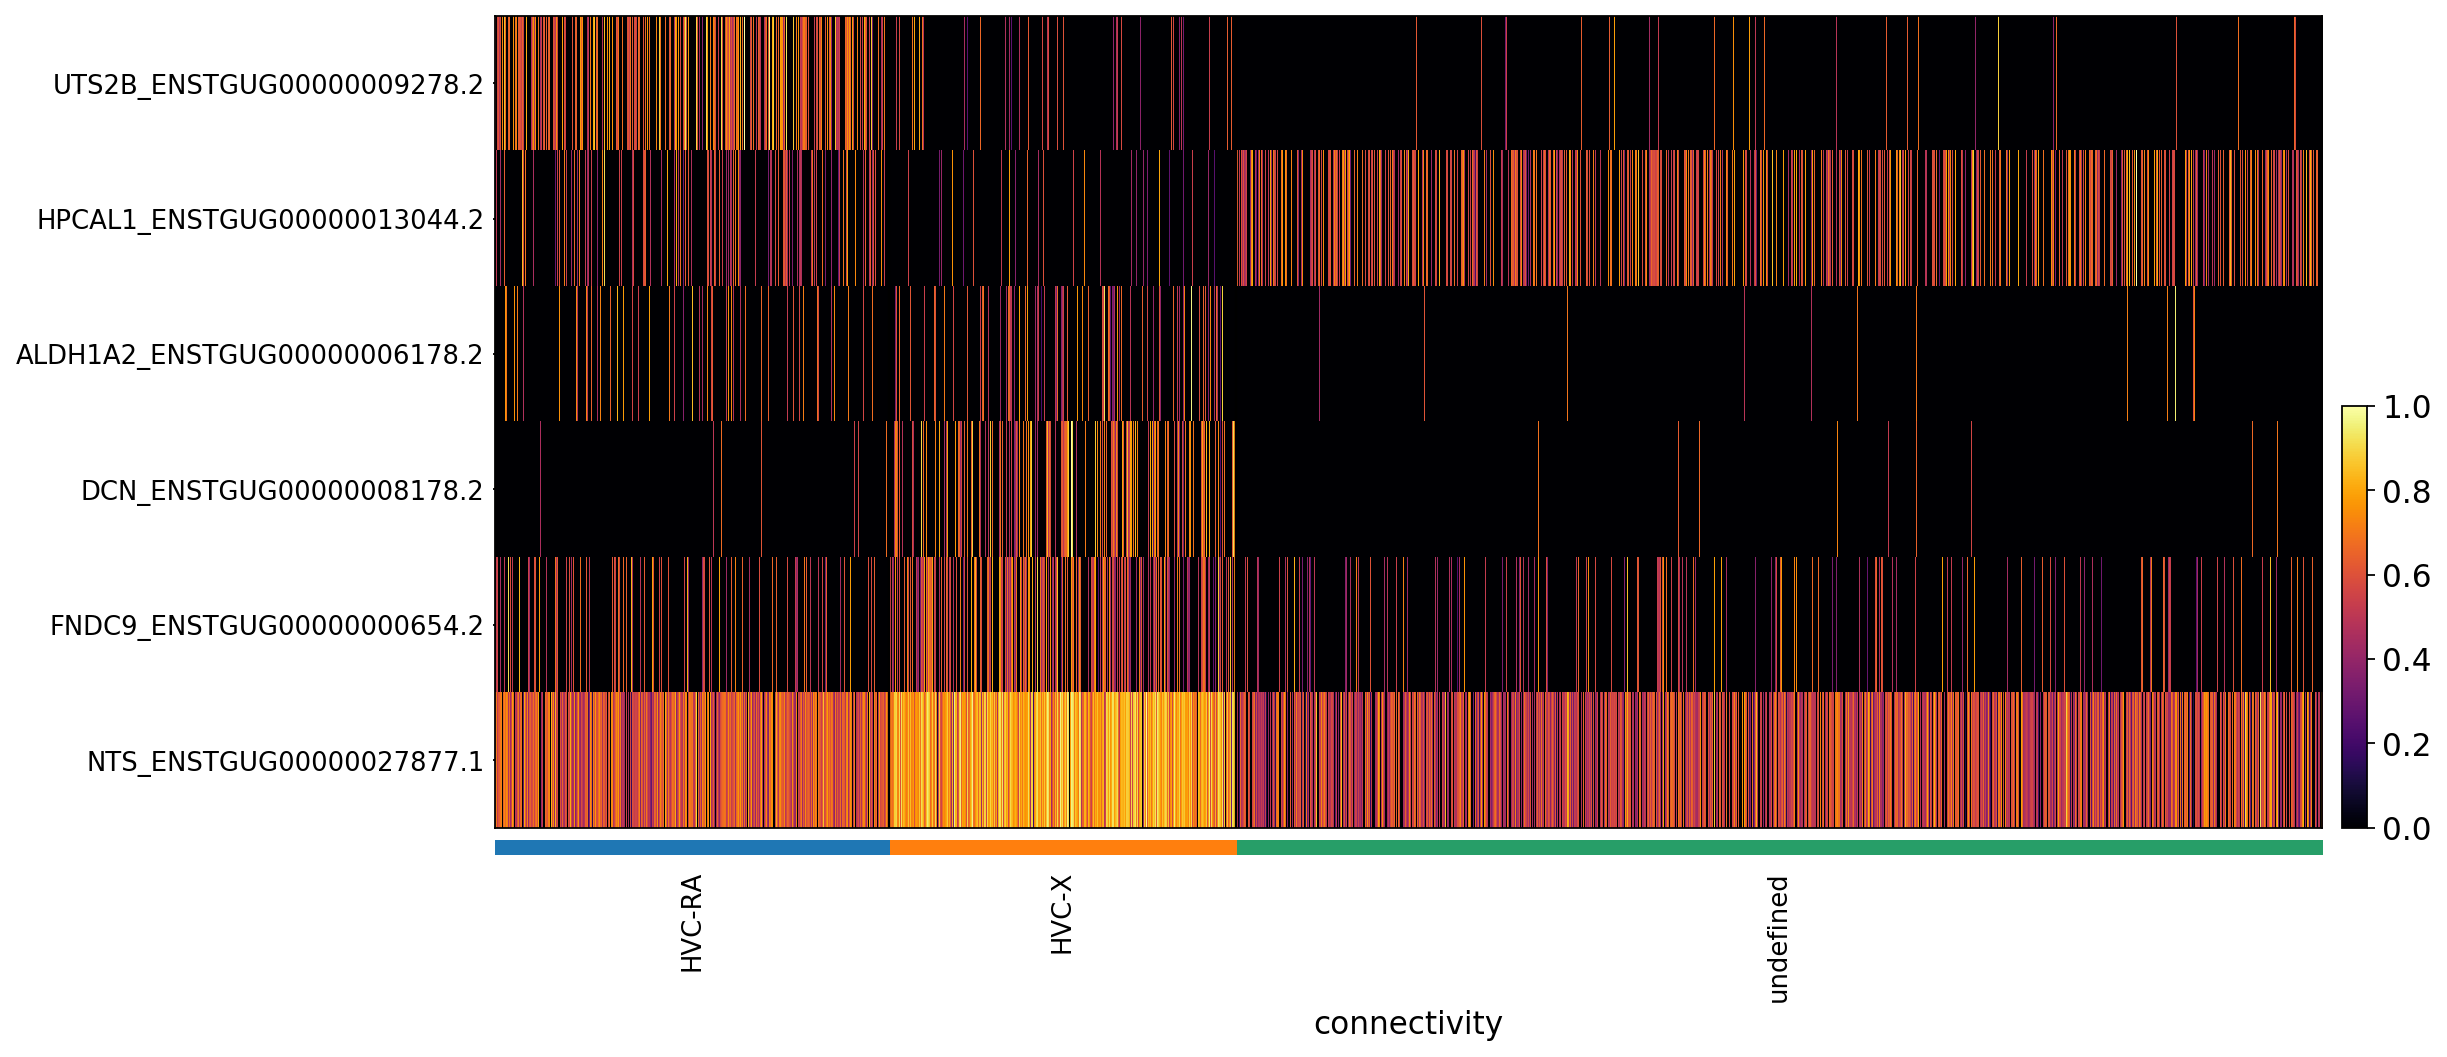

In [83]:
sc.pl.heatmap(
    adata[np.char.startswith(nd(adata.obs.celltype.values).astype(str), "glutamatergic neurons")],
    markers,
    groupby="connectivity",
    show_gene_labels=True,
    use_raw=False, # By default adata.raw.X is plotted. If use_raw=False is set, then adata.X is plotted. 
    cmap="inferno", # Alternative cmap: magma
    standard_scale="var", # standardize that dimension between 0 and 1, meaning for each variable or observation, subtract the minimum and divide each by its maximum
    swap_axes=True,
    figsize=(15, 7)
)

UTS2B (Urotensin 2B): Among its related pathways are Peptide ligand-binding receptors and Signaling by GPCR. Gene Ontology (GO) annotations related to this gene include hormone activity and G protein-coupled receptor binding.  

HPCAL1 (Hippocalcin Like 1): The protein encoded by this gene is a member of neuron-specific calcium-binding proteins family found in the retina and brain. It is highly similar to human hippocalcin protein and nearly identical to the rat and mouse hippocalcin like-1 proteins. It may be involved in the calcium-dependent regulation of rhodopsin phosphorylation and may be of relevance for neuronal signalling in the central nervous system.   

ALDH1A2 (Aldehyde Dehydrogenase 1 Family Member A2): This protein belongs to the aldehyde dehydrogenase family of proteins. The product of this gene is an enzyme that catalyzes the synthesis of retinoic acid (RA) from retinaldehyde. Retinoic acid, the active derivative of vitamin A (retinol), is a hormonal signaling molecule that functions in developing and adult tissues. The studies of a similar mouse gene suggest that this enzyme and the cytochrome CYP26A1, concurrently establish local embryonic retinoic acid levels which facilitate posterior organ development and prevent spina bifida.  

DCN (decorin): This gene encodes a member of the small leucine-rich proteoglycan family of proteins. Alternative splicing results in multiple transcript variants, at least one of which encodes a preproprotein that is proteolytically processed to generate the mature protein. This protein plays a role in collagen fibril assembly. Binding of this protein to multiple cell surface receptors mediates its role in tumor suppression, including a stimulatory effect on autophagy and inflammation and an inhibitory effect on angiogenesis and tumorigenesis.

FNDC9 (Fibronectin Type III Domain Containing 9): Fibronectin is a high-molecular weight glycoprotein of the extracellular matrix that binds to membrane-spanning receptor proteins called integrins (https://en.wikipedia.org/wiki/Fibronectin).

NTS (Neurotensin): This gene encodes a common precursor for two peptides, neuromedin N and neurotensin. Neurotensin is a secreted tridecapeptide, which is widely distributed throughout the central nervous system, and may function as a neurotransmitter or a neuromodulator. It may be involved in dopamine-associated pathophysiological events, in the maintenance of gut structure and function, and in the regulation of fat metabolism. Neurotensin also exhibits antimicrobial activity against bacteria and fungi. Tissue-specific processing may lead to the formation in some tissues of larger forms of neuromedin N and neurotensin. The large forms may represent more stable peptides that are also biologically active.

Info from GeneCards unless otherwise noted

___